# Catch 4 Critters EEG - TFR analysis

In [1]:
# Import relevant packages
import os
import numpy as np
import mne
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Define data file locations etc
homeDir = '/Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/'
os.chdir(homeDir)

# set montage file
montage = homeDir + "montage/m.elp"
subjects = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14',
           'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 
            'S29', 'S30'] # Only analyzing 18-30 for now

filename = 'dataClean-epo.fif'

In [3]:
# load data
#subs = [18, 19, 20, 21, 22,  24, 25, 27, 29]
reref = True # apply current source density re-referencing
subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23,  24, 25, 27,29,  30]

evokedL_dictAll= dict()
evokedO_dictAll= dict()

# TFR parameters
decim = 5
frequencies = np.logspace(*np.log10([2, 45]), num = 15)  # define frequencies of interest
n_cycles = frequencies / 5.  # different number of cycle per frequency

for i in subs:
    subInd = i - 1
    
    
    evokedL_dict= dict()
    evokedO_dict= dict()

    #load data
    datafile = os.path.join(homeDir, subjects[subInd], filename)
    epoch = mne.read_epochs(datafile, preload=True)
    if reref:
        epoch = mne.preprocessing.compute_current_source_density(epoch)
    
    # Filter
    #epochs.filter(None,20, picks = 'all', fir_design = 'firwin')
    
    # Run TFR
    # Implement TFR magic

    Fs = epoch.info['sfreq']  # sampling in Hz

    #data = epochs.get_data()
    #print(data.shape)

    from mne.time_frequency import tfr_morlet
    epochs = tfr_morlet(epoch, freqs=frequencies,n_cycles=n_cycles, use_fft=False, decim=decim, zero_mean=True, average = False, return_itc = False)
    print(epochs._data.shape)
    print ('done!')
    
    #epochs.metadata = epoch.metadata
    
    # Separate different conditions 
    indO = epochs.metadata['blockType'] == 'Orienting'
    indL = (epochs.metadata['blockType'] == 'Learning') # take only trials with at least one exposure
    indEarly = epochs.metadata['Delay'] < 2300
    indLate = epochs.metadata['Delay'] > 2300
    indRand = epochs.metadata['Condition'] == 'random'
    indPred = epochs.metadata['Condition'] == 'predicted'
    indLeft = epochs.metadata['TargetX'] < 0
    indRight = epochs.metadata['TargetX'] > 0
    indLeft1 = epochs.metadata['target1X'] < 0
    indRight1 = epochs.metadata['target1X'] > 0
    indRespL = epochs.metadata['Answer'] < 6
    indRespR = epochs.metadata['Answer'] > 5
    indCorrect = epochs.metadata['correct'] == 1
    indnRep1 = epochs.metadata['nRep'] == 1
    indnRep2 = epochs.metadata['nRep'] == 2
    indnRep3 = epochs.metadata['nRep'] == 3
    indnRep4 = epochs.metadata['nRep'] == 4
    indnRep5 = epochs.metadata['nRep'] == 5
    indnRep6 = epochs.metadata['nRep'] == 6
    indRespCorrL = epochs.metadata['TargetCorrectButton'] <3.0
    indRespCorrR = epochs.metadata['TargetCorrectButton'] > 2.0
    
    
    # separate conditions by place of visual target
    evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft].average()
    evokedO_dict['Early/Random/Right'] = epochs[indO*indEarly*indRand*indRight].average()
    evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft].average()
    evokedO_dict['Late/Random/Right'] = epochs[indO*indLate*indRand*indRight].average()
    evokedO_dict['Early/Predicted/Left'] = epochs[indO*indEarly*indPred*indLeft].average()
    evokedO_dict['Early/Predicted/Right'] = epochs[indO*indEarly*indPred*indRight].average()
    evokedO_dict['Late/Predicted/Left'] = epochs[indO*indLate*indPred*indLeft].average()
    evokedO_dict['Late/Predicted/Right'] =epochs[indO*indLate*indPred*indRight].average()
    
    # Separate random/predicted and early/late only
    evokedO_dict['Early/Random'] = epochs[indO*indEarly*indRand].average()
    evokedO_dict['Late/Random'] = epochs[indO*indLate*indRand].average()
    evokedO_dict['Early/Predicted'] = epochs[indO*indEarly*indPred].average()
    evokedO_dict['Late/Predicted'] = epochs[indO*indLate*indPred].average()
    
    # collapse over early/late
    evokedO_dict['Random/Left'] = epochs[np.logical_or(indO&indEarly&indRand&indLeft, indO&indLate&indRand&indRight) ].average()
    evokedO_dict['Random/Right'] = epochs[np.logical_or(indO&indEarly&indRand&indRight, indO&indLate&indRand&indLeft)].average()
    evokedO_dict['Predicted/Left'] = epochs[np.logical_or(indO&indEarly&indPred&indLeft, indO&indLate&indPred&indRight) ].average()
    evokedO_dict['Predicted/Right'] = epochs[np.logical_or(indO&indEarly&indPred&indRight, indO&indLate&indPred&indLeft )].average()
    
    # Separate by left/right hand response
    evokedO_dict['Early/Random/RespLeft'] = epochs[indO*indEarly*indRand*indRespL].average()
    evokedO_dict['Early/Random/RespRight'] = epochs[indO*indEarly*indRand*indRespR].average()
    evokedO_dict['Late/Random/RespLeft'] = epochs[indO*indLate*indRand*indRespL].average()
    evokedO_dict['Late/Random/RespRight'] = epochs[indO*indLate*indRand*indRespR].average()
    evokedO_dict['Early/Predicted/RespLeft'] = epochs[indO*indEarly*indPred*indRespL].average()
    evokedO_dict['Early/Predicted/RespRight'] = epochs[indO*indEarly*indPred*indRespR].average()
    evokedO_dict['Late/Predicted/RespLeft'] = epochs[indO*indLate*indPred*indRespL].average()
    evokedO_dict['Late/Predicted/RespRight'] =epochs[indO*indLate*indPred*indRespR].average()
    
    # Separate by left/right hand response -- correct response i.e. expected hand resp
    evokedO_dict['Early/Random/RespLeftC'] = epochs[indO*indEarly*indRand*indRespCorrL].average()
    evokedO_dict['Early/Random/RespRightC'] = epochs[indO*indEarly*indRand*indRespCorrR].average()
    evokedO_dict['Late/Random/RespLeftC'] = epochs[indO*indLate*indRand*indRespCorrL].average()
    evokedO_dict['Late/Random/RespRightC'] = epochs[indO*indLate*indRand*indRespCorrR].average()
    evokedO_dict['Early/Predicted/RespLeftC'] = epochs[indO*indEarly*indPred*indRespCorrL].average()
    evokedO_dict['Early/Predicted/RespRightC'] = epochs[indO*indEarly*indPred*indRespCorrR].average()
    evokedO_dict['Late/Predicted/RespLeftC'] = epochs[indO*indLate*indPred*indRespCorrL].average()
    evokedO_dict['Late/Predicted/RespRightC'] =epochs[indO*indLate*indPred*indRespCorrR].average()
    
    evokedL_dict['Random/Left'] = epochs[indL*indRand*indLeft1].average() # Left animal first
    evokedL_dict['Random/Right'] = epochs[indL*indRand*indRight1].average()
    evokedL_dict['Predicted/Left'] = epochs[indL*indPred*indLeft1].average() # Left animal first
    evokedL_dict['Predicted/Right'] = epochs[indL*indPred*indRight1].average()
    
    evokedL_dict['Random/nRep1'] = epochs[indL*indRand*indnRep1].average()
    evokedL_dict['Predicted/nRep1'] = epochs[indL*indPred*indnRep1].average() 
    evokedL_dict['Random/nRep2'] = epochs[indL*indRand*indnRep2].average()
    evokedL_dict['Predicted/nRep2'] = epochs[indL*indPred*indnRep2].average() 
    evokedL_dict['Random/nRep3'] = epochs[indL*indRand*indnRep3].average()
    evokedL_dict['Predicted/nRep3'] = epochs[indL*indPred*indnRep3].average()
    evokedL_dict['Random/nRep4'] = epochs[indL*indRand*indnRep4].average()
    evokedL_dict['Predicted/nRep4'] = epochs[indL*indPred*indnRep4].average() 
    evokedL_dict['Random/nRep5'] = epochs[indL*indRand*indnRep5].average()
    evokedL_dict['Predicted/nRep5'] = epochs[indL*indPred*indnRep5].average() 
    evokedL_dict['Random/nRep6'] = epochs[indL*indRand*indnRep6].average()
    evokedL_dict['Predicted/nRep6'] = epochs[indL*indPred*indnRep6].average() 
    
    
    
    evokedO_dictAll['S' + str(i)] = evokedO_dict
    evokedL_dictAll['S' + str(i)] = evokedL_dict

Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S01/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
547 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(547, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S03/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
555 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(555, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S06/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
547 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(547, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S07/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
566 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(566, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S10/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
533 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(533, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S11/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
538 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(538, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S12/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
477 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(477, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S14/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
542 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(542, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S16/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
535 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(535, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S17/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
547 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(547, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S18/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
534 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(534, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S19/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
568 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(568, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S20/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
525 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(525, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S21/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
531 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(531, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S22/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
545 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(545, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S23/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
536 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(536, 60, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S24/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
555 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(555, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S25/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
555 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(555, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S27/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
553 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(553, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S29/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
560 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(560, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Reading /Users/yvonnefonken/Documents/Oxford/Research Projects/EEG/Catch4Critters_2019/EEGdata/S30/dataClean-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...    4000.00 ms
        0 CTF compensation matrices available
542 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 45 columns
0 projection items activated
Fitted sphere radius:         85000.0 mm
Origin head coordinates:      -0.0 -0.0 0.2 mm
Origin device coordinates:    -0.0 -0.0 0.2 mm


<ipython-input-3-a1fedfb2e768>:25: RuntimeWarning: Estimated head size (85000.0 mm) exceeded 99th percentile for adult head size
  epoch = mne.preprocessing.compute_current_source_density(epoch)


Adding metadata with 45 columns
(542, 61, 15, 351)
done!


/Users/yvonnefonken/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [ ]:
np.logical_or?

In [ ]:
sum(np.logical_or(indO&indEarly&indRand&indLeft, indO&indLate&indRand&indRight ))

In [ ]:
# load data
#subs = [18, 19, 20, 21, 22, 23,  24, 25, 27, 29, 30]

subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30]
reref = 1
evokedL_dictAll= dict()
evokedO_dictAll= dict()

# TFR parameters
decim = 10
frequencies = np.logspace(*np.log10([2, 45]), num = 15)  # define frequencies of interest
n_cycles = frequencies / 5.  # different number of cycle per frequency

for i in subs:
    subInd = i - 1
    
    
    evokedL_dict= dict()
    evokedO_dict= dict()

    #load data
    datafile = os.path.join(homeDir, subjects[subInd], filename)
    epoch = mne.read_epochs(datafile, preload=True)
    if reref:
        epoch = mne.preprocessing.compute_current_source_density(epoch)
    # Filter
    #epochs.filter(None,20, picks = 'all', fir_design = 'firwin')
    
    # Run TFR
    # Implement TFR magic

    Fs = epoch.info['sfreq']  # sampling in Hz

    #data = epochs.get_data()
    #print(data.shape)

    from mne.time_frequency import tfr_morlet
    epochs = tfr_morlet(epoch, freqs=frequencies,n_cycles=n_cycles, use_fft=False, decim=decim, zero_mean=True, average = False, return_itc = False)
    print(epochs._data.shape)
    print ('done!')
    
    #epochs.metadata = epoch.metadata
    
    # Separate different conditions 
    indO = epochs.metadata['blockType'] == 'Orienting'
    indL = (epochs.metadata['blockType'] == 'Learning') # take only trials with at least one exposure
    indEarly = epochs.metadata['Delay'] < 2300
    indLate = epochs.metadata['Delay'] > 2300
    indRand = epochs.metadata['Condition'] == 'random'
    indPred = epochs.metadata['Condition'] == 'predicted'
    indLeft = epochs.metadata['TargetX'] < 0
    indRight = epochs.metadata['TargetX'] > 0
    indLeft1 = epochs.metadata['target1X'] < 0
    indRight1 = epochs.metadata['target1X'] > 0
    indRespL = epochs.metadata['Answer'] < 6
    indRespR = epochs.metadata['Answer'] > 5
    indCorrect = epochs.metadata['correct'] == 1
    indnRep1 = epochs.metadata['nRep'] == 1
    indnRep2 = epochs.metadata['nRep'] == 2
    indnRep3 = epochs.metadata['nRep'] == 3
    indnRep4 = epochs.metadata['nRep'] == 4
    indnRep5 = epochs.metadata['nRep'] == 5
    indnRep6 = epochs.metadata['nRep'] == 6
    
    
    # separate conditions by place of visual target
    evokedO_dict['Early/Random/Left'] = epochs[indO*indEarly*indRand*indLeft*indCorrect].average()
    evokedO_dict['Early/Random/Right'] = epochs[indO*indEarly*indRand*indRight*indCorrect].average()
    evokedO_dict['Late/Random/Left'] = epochs[indO*indLate*indRand*indLeft*indCorrect].average()
    evokedO_dict['Late/Random/Right'] = epochs[indO*indLate*indRand*indRight*indCorrect].average()
    evokedO_dict['Early/Predicted/Left'] = epochs[indO*indEarly*indPred*indLeft*indCorrect].average()
    evokedO_dict['Early/Predicted/Right'] = epochs[indO*indEarly*indPred*indRight*indCorrect].average()
    evokedO_dict['Late/Predicted/Left'] = epochs[indO*indLate*indPred*indLeft*indCorrect].average()
    evokedO_dict['Late/Predicted/Right'] =epochs[indO*indLate*indPred*indRight*indCorrect].average()
    
    
    
    # Separate random/predicted and early/late only
    evokedO_dict['Early/Random'] = epochs[indO*indEarly*indRand*indCorrect].average()
    evokedO_dict['Late/Random'] = epochs[indO*indLate*indRand*indCorrect].average()
    evokedO_dict['Early/Predicted'] = epochs[indO*indEarly*indPred*indCorrect].average()
    evokedO_dict['Late/Predicted'] = epochs[indO*indLate*indPred*indCorrect].average()
    
    # Separate by left/right hand response
    evokedO_dict['Early/Random/RespLeft'] = epochs[indO*indEarly*indRand*indRespL*indCorrect].average()
    evokedO_dict['Early/Random/RespRight'] = epochs[indO*indEarly*indRand*indRespR*indCorrect].average()
    evokedO_dict['Late/Random/RespLeft'] = epochs[indO*indLate*indRand*indRespL*indCorrect].average()
    evokedO_dict['Late/Random/RespRight'] = epochs[indO*indLate*indRand*indRespR*indCorrect].average()
    evokedO_dict['Early/Predicted/RespLeft'] = epochs[indO*indEarly*indPred*indRespL*indCorrect].average()
    evokedO_dict['Early/Predicted/RespRight'] = epochs[indO*indEarly*indPred*indRespR*indCorrect].average()
    evokedO_dict['Late/Predicted/RespLeft'] = epochs[indO*indLate*indPred*indRespL*indCorrect].average()
    evokedO_dict['Late/Predicted/RespRight'] =epochs[indO*indLate*indPred*indRespR*indCorrect].average()
    
    evokedL_dict['Random/Left'] = epochs[indL*indRand*indLeft1*indCorrect].average() # Left animal first
    evokedL_dict['Random/Right'] = epochs[indL*indRand*indRight1*indCorrect].average()
    evokedL_dict['Predicted/Left'] = epochs[indL*indPred*indLeft1*indCorrect].average() # Left animal first
    evokedL_dict['Predicted/Right'] = epochs[indL*indPred*indRight1*indCorrect].average()
    
    evokedL_dict['Random/nRep1'] = epochs[indL*indRand*indnRep1*indCorrect].average()
    evokedL_dict['Predicted/nRep1'] = epochs[indL*indPred*indnRep1*indCorrect].average() 
    evokedL_dict['Random/nRep2'] = epochs[indL*indRand*indnRep2*indCorrect].average()
    evokedL_dict['Predicted/nRep2'] = epochs[indL*indPred*indnRep2*indCorrect].average() 
    evokedL_dict['Random/nRep3'] = epochs[indL*indRand*indnRep3*indCorrect].average()
    evokedL_dict['Predicted/nRep3'] = epochs[indL*indPred*indnRep3*indCorrect].average()
    evokedL_dict['Random/nRep4'] = epochs[indL*indRand*indnRep4*indCorrect].average()
    evokedL_dict['Predicted/nRep4'] = epochs[indL*indPred*indnRep4*indCorrect].average() 
    evokedL_dict['Random/nRep5'] = epochs[indL*indRand*indnRep5*indCorrect].average()
    evokedL_dict['Predicted/nRep5'] = epochs[indL*indPred*indnRep5*indCorrect].average() 
    evokedL_dict['Random/nRep6'] = epochs[indL*indRand*indnRep6*indCorrect].average()
    evokedL_dict['Predicted/nRep6'] = epochs[indL*indPred*indnRep6*indCorrect].average() 
    
    
    
    evokedO_dictAll['S' + str(i)] = evokedO_dict
    evokedL_dictAll['S' + str(i)] = evokedL_dict

In [ ]:
# redo trials to collapse early/late in orienting?

In [ ]:
# Calculate grandaverage
# Create dictionary of grandaverage objects per condition
GAVG_orienting = dict()
subs = [18, 19, 20, 21, 22,  24, 25, 27, 29, 30]


#subs = [1, 3, 6, 7,  10,  11,12, 14, 16, 17, 18, 19,  20, 21, 22, 24, 25, 27,29, 30] # left out 23 because of error with bad channels
num = 0
for j in list(evokedO_dictAll['S18'].keys()):
    all_inst = []
    for i in subs:
        all_inst.append(evokedO_dictAll['S'+ str(i)][j])

    GAVG_orienting[j] =  mne.grand_average(all_inst, interpolate_bads=True, drop_bads=False)

    
GAVG_learning = dict()


num = 0
for j in list(evokedL_dictAll['S18'].keys()):
    all_inst = []
    for i in subs:
        all_inst.append(evokedL_dictAll['S'+ str(i)][j])

    GAVG_learning[j] =  mne.grand_average(all_inst, interpolate_bads=True, drop_bads=False)

In [ ]:
evokedL_dictAll['S18']['Predicted/Left'].times

In [ ]:
# use tsplot instead ORIENTING


ElecOI = 'PO8'

# Baseline 
baseline = [-1.8, -1.5]

times = evokedO_dictAll['S18']['Early/Predicted/Left'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 8.0) * (frequencies < 13.)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[2]))

PowLdict = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy(), 'Late/Random/Right': emptyNp.copy(),  'Late/Predicted/Right': emptyNp.copy(), 
      'Late/Random/Left': emptyNp.copy(),   'Late/Predicted/Left': emptyNp.copy()}
num = 0
for i in subs:
    
    
    Ind = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    
    PowLdict['Early/Random/Right'][num,:] = 100* (np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Early/Predicted/Right'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[Ind,freqInd,:], axis = 0) - Base)/Base
    
    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[Ind,freqInd,:], axis = 0)
    Base = np.mean(Base[tBL])
    PowLdict['Early/Random/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[Ind,freqInd,:], axis = 0) - Base)/Base 

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Early/Predicted/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    
    PowLdict['Late/Random/Right'][num,:] = 100* (np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Late/Predicted/Right'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[Ind,freqInd,:], axis = 0) - Base)/Base
    
    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[Ind,freqInd,:], axis = 0)
    Base = np.mean(Base[tBL])
    PowLdict['Late/Random/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[Ind,freqInd,:], axis = 0) - Base)/Base 

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Late/Predicted/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[Ind,freqInd,:], axis = 0)  - Base)/Base


    #LRdictAll['S' + str(i)] = LRdict
    num += 1




#ax.axhline(.5, color='k', linestyle='--', label='chance')
#ax.axvline(0.8, color = 'gray', linestyle = '-', label = 'Target')
#ax.axvline(2.0, color = 'gray', linestyle = '-', )
#ax.set_xlabel('time')
#ax.legend()

#ax.set_title('Learning: Alpha power')

In [ ]:
# use tsplot instead ORIENTING -- collapsed across early/late -- doesn't work yet


ElecOI = 'PO8'

# Baseline 
baseline = [-1.8, -1.5]

times = evokedO_dictAll['S18']['Early/Predicted/Left'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 7.0) * (frequencies < 14.)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Random/Left'].data.shape[2]))

PowLdict = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy()}
num = 0
for i in subs:
    
    
    Ind = evokedO_dictAll['S' + str(i)]['Random/Left'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Random/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    
    PowLdict['Early/Random/Right'][num,:] = 100* (np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Predicted/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Early/Predicted/Right'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[Ind,freqInd,:], axis = 0) - Base)/Base
    
    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Random/Left'].data[Ind,freqInd,:], axis = 0)
    Base = np.mean(Base[tBL])
    PowLdict['Early/Random/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[Ind,freqInd,:], axis = 0) - Base)/Base 

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Predicted/Left'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Early/Predicted/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    

    #LRdictAll['S' + str(i)] = LRdict
    num += 1



In [ ]:
# plot tsplot individual frequency bands
fig, ax = plt.subplots(figsize = (20,8))
#fig.figsize = (10,20)
sb.tsplot(data = PowLdict['Early/Predicted/Left'], time = times, color = 'Crimson', linestyle = '-', ax = ax)
sb.tsplot(data = PowLdict['Early/Predicted/Right'], time = times, color = 'Crimson', linestyle = '--', ax = ax)
sb.tsplot(data = PowLdict['Early/Random/Left'], time = times, color = 'CornFlowerBlue', linestyle = '-', ax = ax)
sb.tsplot(data = PowLdict['Early/Random/Right'], time = times, color = 'CornFlowerBlue', linestyle = '--', ax = ax)

ax.axhline(.5, color='k', linestyle='-')
ax.axvline(0.8, color = 'gray', linestyle = '-', label = 'trial events')
ax.axvline(2.0, color = 'gray', linestyle = '-' )
ax.axvline(-1.2, color = 'gray', linestyle = '-' )
ax.axvline(0.0, color = 'gray', linestyle = '-')
ax.set_xlabel('time (s)')
ax.set_ylabel('Power (%)')
ax.legend()

ax.set_title('Learning: Alpha power for electrode ' + ElecOI)

In [ ]:
# use tsplot instead ORIENTING early/late predicted/random -- no left/right


ElecOI = 'PO8'

# Baseline 
baseline = [-1.8, -1.5]

times = evokedO_dictAll['S18']['Early/Predicted'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 8.0) * (frequencies < 12.)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random'].data.shape[2]))

PowLdict = {'Early/Random': emptyNp.copy(),  'Early/Predicted': emptyNp.copy(), 
      'Late/Random': emptyNp.copy(),   'Late/Predicted': emptyNp.copy(), }
num = 0
for i in subs:
    
    
    Ind = evokedO_dictAll['S' + str(i)]['Early/Random'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    
    PowLdict['Early/Random'][num,:] = 100* (np.mean(evokedO_dictAll['S' + str(i)]['Early/Random'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Early/Predicted'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted'].data[Ind,freqInd,:], axis = 0) - Base)/Base
    
 
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    
    PowLdict['Late/Random'][num,:] = 100* (np.mean(evokedO_dictAll['S' + str(i)]['Late/Random'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Late/Predicted'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted'].data[Ind,freqInd,:], axis = 0) - Base)/Base
    


    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [ ]:
# plot tsplot individual frequency bands
fig, ax = plt.subplots(figsize = (20,8))
#fig.figsize = (10,20)
sb.tsplot(data = PowLdict['Early/Predicted'], time = times, color = 'Crimson', linestyle = '-', ax = ax)
sb.tsplot(data = PowLdict['Late/Predicted'], time = times, color = 'Crimson', linestyle = '--', ax = ax)
sb.tsplot(data = PowLdict['Early/Random'], time = times, color = 'CornFlowerBlue', linestyle = '-', ax = ax)
sb.tsplot(data = PowLdict['Late/Random'], time = times, color = 'CornFlowerBlue', linestyle = '--', ax = ax)

ax.axhline(.5, color='k', linestyle='-')
ax.axvline(0.8, color = 'gray', linestyle = '-', label = 'trial events')
ax.axvline(2.0, color = 'gray', linestyle = '-' )
ax.axvline(-1.2, color = 'gray', linestyle = '-' )
ax.axvline(0.0, color = 'gray', linestyle = '-')
ax.set_xlabel('time (s)')
ax.set_ylabel('Power (%)')
ax.set_ylim([-75, 75])
ax.legend()

ax.set_title('Learning: Alpha power for electrodes ' + ElecOI)

In [ ]:
subs

In [16]:
# use tsplot instead ORIENTING early/late predicted/random -- no left/right -- average across channels


ElecOI = ['FZ', 'AFZ', 'F1', 'F2', 'AF3', 'AF4'] #['PO8', 'PO7', 'PO3', 'PO4', 'POZ', 'OZ', 'O1', 'O2', 'PZ', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
picks = []
for j in ElecOI:
    picks.append(evokedO_dictAll['S18']['Early/Random'].ch_names.index(j))

#subs = [18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30]
subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23,  24, 25, 27,29,  30]
#subs = [11, 12, 14, 16, 17, 22, 23, 24,  29, 30] # add 29

# Baseline 
baseline = [-1.8, -1.5]

times = evokedO_dictAll['S18']['Early/Predicted'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 2.) * (frequencies < 8.)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random'].data.shape[2]))

PowLdict = {'Early/Random': emptyNp.copy(),  'Early/Predicted': emptyNp.copy(), 
      'Late/Random': emptyNp.copy(),   'Late/Predicted': emptyNp.copy() , 'Random': emptyNp.copy(),   'Predicted': emptyNp.copy() }
num = 0
for i in subs:
    
    picks = []
    for j in ElecOI:
        picks.append(evokedO_dictAll['S' + str(i)]['Early/Random'].ch_names.index(j))
    #Ind = evokedO_dictAll['S' + str(i)]['Early/Random'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random'].data[picks,:,:], axis = 0)
    SelecFreq = np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[tBL])
    PowLdict['Early/Random'][num,:]= 100*(SelecFreq - Base)/Base
    
    del Base, SelecChan, SelecFreq
    
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random'].data[picks,:,:], axis = 0)
    SelecFreq = np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[tBL])
    PowLdict['Late/Random'][num,:]= 100*(SelecFreq - Base)/Base
 
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted'].data[picks,:,:], axis = 0)
    SelecFreq = np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[tBL])
    PowLdict['Early/Predicted'][num,:]= 100*(SelecFreq - Base)/Base
    
    del Base, SelecChan, SelecFreq
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted'].data[picks,:,:], axis = 0)
    SelecFreq = np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[tBL])
    PowLdict['Late/Predicted'][num,:]= 100*(SelecFreq - Base)/Base
    
    PowLdict['Predicted'][num,:] = (PowLdict['Late/Predicted'][num,:] + PowLdict['Early/Predicted'][num,:])/2
    PowLdict['Random'][num,:] = (PowLdict['Late/Random'][num,:] + PowLdict['Early/Random'][num,:])/2
    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [ ]:
# use tsplot instead ORIENTING early/late predicted/random -- no left/right -- average across channels
# NO BASELINE

ElecOI = ['AFZ'] #['PO8', 'PO7', 'PO3', 'PO4', 'POZ', 'OZ', 'O1', 'O2', 'PZ', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
picks = []
for j in ElecOI:
    picks.append(evokedO_dictAll['S18']['Early/Random'].ch_names.index(j))

#subs = [18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30]
#subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23,  24, 25, 27,29,  30]
subs = [11, 12, 14, 16, 17, 22, 23, 24,  29, 30] # add 29

# Baseline 
baseline = [-1.8, -1.5]

times = evokedO_dictAll['S18']['Early/Predicted'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 2.) * (frequencies < 8.)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random'].data.shape[2]))

PowLdict = {'Early/Random': emptyNp.copy(),  'Early/Predicted': emptyNp.copy(), 
      'Late/Random': emptyNp.copy(),   'Late/Predicted': emptyNp.copy() , 'Random': emptyNp.copy(),   'Predicted': emptyNp.copy() }
num = 0
for i in subs:
    
    picks = []
    for j in ElecOI:
        picks.append(evokedO_dictAll['S' + str(i)]['Early/Random'].ch_names.index(j))
    #Ind = evokedO_dictAll['S' + str(i)]['Early/Random'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random'].data[picks,:,:], axis = 0)
    SelecFreq = np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[tBL])
    PowLdict['Early/Random'][num,:]= SelecFreq#100*(SelecFreq - Base)/Base
    
    del Base, SelecChan, SelecFreq
    
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random'].data[picks,:,:], axis = 0)
    SelecFreq = np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[tBL])
    PowLdict['Late/Random'][num,:]= SelecFreq #100*(SelecFreq - Base)/Base
 
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted'].data[picks,:,:], axis = 0)
    SelecFreq = np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[tBL])
    PowLdict['Early/Predicted'][num,:]= SelecFreq #100*(SelecFreq - Base)/Base
    
    del Base, SelecChan, SelecFreq
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted'].data[picks,:,:], axis = 0)
    SelecFreq = np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[tBL])
    PowLdict['Late/Predicted'][num,:]= SelecFreq #100*(SelecFreq - Base)/Base
    
    PowLdict['Predicted'][num,:] = (PowLdict['Late/Predicted'][num,:] + PowLdict['Early/Predicted'][num,:])/2
    PowLdict['Random'][num,:] = (PowLdict['Late/Random'][num,:] + PowLdict['Early/Random'][num,:])/2
    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [ ]:
PowLdict['Early/Predicted']

Text(0.5, 1.0, 'Orienting:  power for electrodes FZ AFZ F1 F2 AF3 AF4')

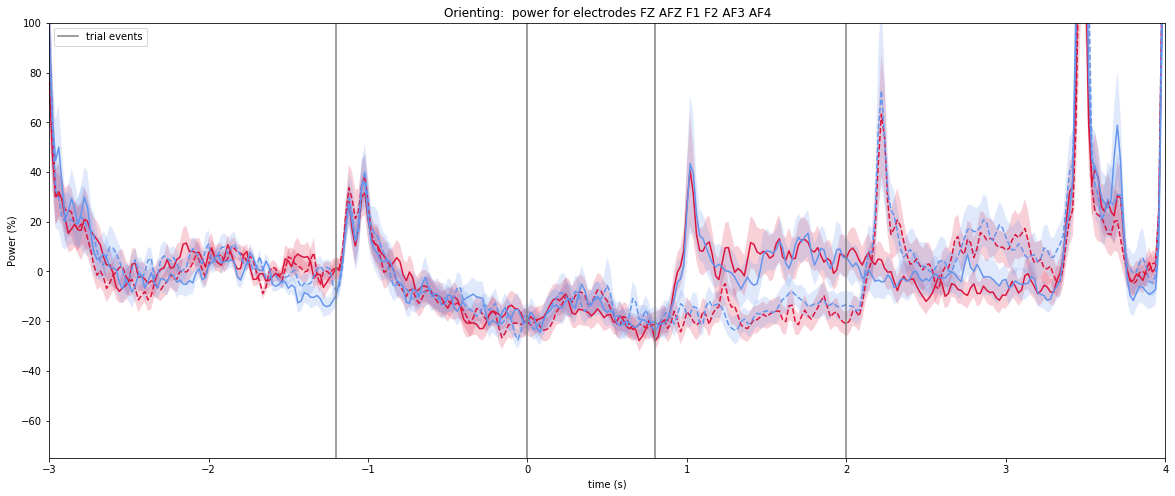

In [17]:
# plot tsplot individual frequency bands
%matplotlib inline

fig, ax = plt.subplots(figsize = (20,8))
#fig.figsize = (10,20)
sb.tsplot(data = PowLdict['Early/Predicted'], time = times, color = 'Crimson', linestyle = '-', ax = ax)
sb.tsplot(data = PowLdict['Late/Predicted'], time = times, color = 'Crimson', linestyle = '--', ax = ax)
sb.tsplot(data = PowLdict['Early/Random'], time = times, color = 'CornFlowerBlue', linestyle = '-', ax = ax)
sb.tsplot(data = PowLdict['Late/Random'], time = times, color = 'CornFlowerBlue', linestyle = '--', ax = ax)

#ax.axhline(.5, color='k', linestyle='-')
ax.axvline(0.8, color = 'gray', linestyle = '-', label = 'trial events')
ax.axvline(2.0, color = 'gray', linestyle = '-' )
ax.axvline(-1.2, color = 'gray', linestyle = '-' )
ax.axvline(0.0, color = 'gray', linestyle = '-')
ax.set_xlabel('time (s)')
ax.set_ylabel('Power (%)')
ax.set_ylim([-75, 100])
ax.legend()

ax.set_title('Orienting:  power for electrodes ' + ' '.join(ElecOI))

In [ ]:
subs

In [ ]:
# use tsplot instead ORIENTING early/late predicted/random -- no left/right -- average across channels CREATE FOR TFR


ElecOI = ['PO7', 'PO8'] #['PO8', 'PO7', 'PO3', 'PO4', 'POZ', 'OZ', 'O1', 'O2', 'PZ', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
picks = []
for j in ElecOI:
    picks.append(evokedO_dictAll['S18']['Early/Random'].ch_names.index(j))

#subs = [18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30]
#subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23,  24, 25, 27,29,  30]
subs = [11, 12, 14, 16, 17, 22, 23, 24,  30] # add 29

# Baseline 
baseline = [-1.8, -1.5]

times = evokedO_dictAll['S18']['Early/Predicted'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

#freqInd = (frequencies > 13.) * (frequencies < 30.)

emptyNp = np.zeros((len(subs),evokedO_dictAll['S18']['Early/Random'].data.shape[1],  evokedO_dictAll['S18']['Early/Random'].data.shape[2]))

PowOdict = {'Early/Random': emptyNp.copy(),  'Early/Predicted': emptyNp.copy(), 
      'Late/Random': emptyNp.copy(),   'Late/Predicted': emptyNp.copy() , 'Random': emptyNp.copy(),  
            'Predicted': emptyNp.copy(), 'Diff': emptyNp.copy(), 'LateDiff': emptyNp.copy(), 'EarlyDiff': emptyNp.copy()}
num = 0
for i in subs:
    
    picks = []
    for j in ElecOI:
        picks.append(evokedO_dictAll['S' + str(i)]['Early/Random'].ch_names.index(j))
    #Ind = evokedO_dictAll['S' + str(i)]['Early/Random'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random'].data[picks,:,:], axis = 0)
    SelecFreq = SelecChan#np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[:,tBL], axis = 1)
    PowOdict['Early/Random'][num,:,:]= 100*(SelecFreq - Base[:,None])/Base[:,None]
    
    del Base, SelecChan, SelecFreq
    
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random'].data[picks,:,:], axis = 0)
    SelecFreq = SelecChan#SelecChan#np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[:,tBL], axis =1)
    PowOdict['Late/Random'][num,:,:]= 100*(SelecFreq - Base[:,None])/Base[:,None]
 
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted'].data[picks,:,:], axis = 0)
    SelecFreq = SelecChan#np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[:,tBL], axis = 1)
    PowOdict['Early/Predicted'][num,:,:]= 100*(SelecFreq - Base[:,None])/Base[:,None]
    
    del Base, SelecChan, SelecFreq
    SelecChan = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted'].data[picks,:,:], axis = 0)
    SelecFreq = SelecChan#np.mean(SelecChan[freqInd,:], axis = 0)
    Base  = np.mean(SelecFreq[:,tBL], axis = 1)
    PowOdict['Late/Predicted'][num,:,:]= 100*(SelecFreq - Base[:,None])/Base[:,None]
    
    PowOdict['Predicted'][num,:,:] = (PowOdict['Late/Predicted'][num,:] + PowOdict['Early/Predicted'][num,:,:])/2
    PowOdict['Random'][num,:,:] = (PowOdict['Late/Random'][num,:] + PowOdict['Early/Random'][num,:,:])/2
    
    PowOdict['EarlyDiff'][num,:,:] = (PowOdict['Early/Random'][num,:] - PowOdict['Early/Predicted'][num,:,:])
    PowOdict['LateDiff'][num,:,:] = (PowOdict['Late/Random'][num,:] - PowOdict['Late/Predicted'][num,:,:])
    PowOdict['Diff'][num,:,:] = (PowOdict['Random'][num,:] - PowOdict['Predicted'][num,:,:])
    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [ ]:
# Plot TFR
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (20,10))
fig.subplots_adjust(hspace=0.3)

fig.suptitle('Time-frequency across channels  ' + ' '.join(ElecOI))

freqInd = frequencies > 1.0
tInd = (times > -2.0) 

cmap = 'coolwarm'
vmin = -50.
vmax = 50.

yLbl = np.round(frequencies, 1)
xLbl= times
xticks = []
for i in xLbl: 
    if i%0.5 == 0.0:
        xticks.append(i)
    else: 
        xticks.append('')

sb.heatmap(data = np.mean(PowOdict['Late/Predicted'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[0,1], cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[0,1].invert_yaxis()
axes[0,1].set(title= 'Late Predicted')        
        
sb.heatmap(data = np.mean(PowOdict['Early/Predicted'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[0,0], cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[0,0].invert_yaxis()
axes[0,0].set(title= 'Early Predicted')        
        
sb.heatmap(data = np.mean(PowOdict['Late/Random'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[1,1],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[1,1].invert_yaxis()
axes[1,1].set(title= 'Late Random')        
        
sb.heatmap(data = np.mean(PowOdict['Early/Random'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[1,0],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[1,0].invert_yaxis()
axes[1,0].set(title= 'Early Random')

sb.heatmap(data = np.mean(PowOdict['EarlyDiff'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[2,0],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[2,0].invert_yaxis()
axes[2,0].set(title= 'Early Diff plot: Random - predicted')

sb.heatmap(data = np.mean(PowOdict['LateDiff'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[2,1],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[2,1].invert_yaxis()
axes[2,1].set(title= 'Late Diff plot: Random- predicted')
#[2,1].axvline(0.0, color = 'gray')


In [14]:
# cluster permutation across time and freq for power differences
from mne.stats import permutation_cluster_test

#twin = [-1.0, 0.] # memory recall window
#twin = [0.2, 0.8] # anticipation window early target
#twin = [1.0, 2.0] # anticipation window late target
twin = [0.8, 1.6] # reaction window early target
#twin = [2.0, 2.8] # reaction window late target


twin = [-1., 0.8] # anticipation window late target
tInd = (times > twin[0]) & (times < twin[1])
condition2 = PowLdict['Early/Random'][:,tInd]
condition1 = PowLdict['Early/Predicted'][:,tInd]

threshold = 1.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=0, n_jobs=1)



stat_fun(H1): min=0.000139 max=1.267785
Running initial clustering
Found 1 clusters
Permuting 999 times...
[........................................] 100.00%  |
Computing cluster p-values
Done.


In [15]:
cluster_p_values

array([0.988])

In [ ]:
# use tsplot instead Learning


ElecOI = 'PO8'

# Baseline 
baseline = [-1.8, -1.5]

times = evokedL_dictAll['S18']['Predicted/Left'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 8.0) * (frequencies < 13.)

emptyNp = np.zeros((len(subs), evokedL_dictAll['S18']['Random/Left'].data.shape[2]))

PowLdict = {'Random/Right': emptyNp.copy(),  'Predicted/Right': emptyNp.copy(), 
      'Random/Left': emptyNp.copy(),   'Predicted/Left': emptyNp.copy()}
num = 0
for i in subs:
    
    
    Ind = evokedL_dictAll['S' + str(i)]['Random/Left'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    Base = np.mean(evokedL_dictAll['S' + str(i)]['Random/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    
    PowLdict['Random/Right'][num,:] = 100* (np.mean(evokedL_dictAll['S' + str(i)]['Random/Right'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    del Base
    Base = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Predicted/Right'][num,:]= 100*(np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Right'].data[Ind,freqInd,:], axis = 0) - Base)/Base
    
    del Base
    Base = np.mean(evokedL_dictAll['S' + str(i)]['Random/Left'].data[Ind,freqInd,:], axis = 0)
    Base = np.mean(Base[tBL])
    PowLdict['Random/Left'][num,:]= 100*(np.mean(evokedL_dictAll['S' + str(i)]['Random/Left'].data[Ind,freqInd,:], axis = 0) - Base)/Base 

    del Base
    Base = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Left'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowLdict['Predicted/Left'][num,:]= 100*(np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Left'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    #LRdictAll['S' + str(i)] = LRdict
    num += 1





In [ ]:
# plot tsplot individual frequency bands
fig, ax = plt.subplots(figsize = (20,8))
#fig.figsize = (10,20)
sb.tsplot(data = PowLdict['Predicted/Left'], time = times, color = 'Crimson', linestyle = '-', ax = ax)
sb.tsplot(data = PowLdict['Predicted/Right'], time = times, color = 'Crimson', linestyle = '--', ax = ax)
sb.tsplot(data = PowLdict['Random/Left'], time = times, color = 'CornFlowerBlue', linestyle = '-', ax = ax)
sb.tsplot(data = PowLdict['Random/Right'], time = times, color = 'CornFlowerBlue', linestyle = '--', ax = ax)

ax.axhline(.5, color='k', linestyle='-')
ax.axvline(0.8, color = 'gray', linestyle = '-', label = 'trial events')
ax.axvline(2.0, color = 'gray', linestyle = '-' )
ax.axvline(-1.2, color = 'gray', linestyle = '-' )
ax.axvline(0.0, color = 'gray', linestyle = '-')
ax.set_xlabel('time (s)')
ax.set_ylabel('Power (%)')
ax.legend()

ax.set_title('Learning: Alpha power for electrode ' + ElecOI)

In [ ]:
subs


In [ ]:
# Power timecourse for motor electordes  -- ORIENTING


ElecOI = 'C3'

# Baseline 
baseline = [-1.8, -1.5]

times = evokedO_dictAll['S18']['Early/Predicted/RespLeftC'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 13.0) * (frequencies < 30.)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/RespLeftC'].data.shape[2]))

PowOdict = {'Random/Right': emptyNp.copy(),  'Predicted/Right': emptyNp.copy(), 
      'Random/Left': emptyNp.copy(),   'Predicted/Left': emptyNp.copy()}
num = 0
for i in subs:
    
    
    Ind = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeftC'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespRightC'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    
    PowOdict['Random/Right'][num,:] = 100* (np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRightC'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowOdict['Predicted/Right'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[Ind,freqInd,:], axis = 0) - Base)/Base
    
    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespLeftC'].data[Ind,freqInd,:], axis = 0)
    Base = np.mean(Base[tBL])
    PowOdict['Random/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[Ind,freqInd,:], axis = 0) - Base)/Base 

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeftC'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowOdict['Predicted/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    #LRdictAll['S' + str(i)] = LRdict
    num += 1





In [ ]:
ax.set

In [ ]:
# plot tsplot individual frequency bands
fig, ax = plt.subplots(figsize = (20,8))
#fig.figsize = (10,20)
sb.tsplot(data = PowOdict['Predicted/Left'], time = times, color = 'Crimson', linestyle = '-', ax = ax)
sb.tsplot(data = PowOdict['Predicted/Right'], time = times, color = 'Crimson', linestyle = '--', ax = ax)
sb.tsplot(data = PowOdict['Random/Left'], time = times, color = 'CornFlowerBlue', linestyle = '-', ax = ax)
sb.tsplot(data = PowOdict['Random/Right'], time = times, color = 'CornFlowerBlue', linestyle = '--', ax = ax)

ax.axhline(.5, color='k', linestyle='-')
ax.axvline(0.8, color = 'gray', linestyle = '-', label = 'trial events')
ax.axvline(2.0, color = 'gray', linestyle = '-' )
ax.axvline(-1.2, color = 'gray', linestyle = '-' )
ax.axvline(0.0, color = 'gray', linestyle = '-')
ax.set_xlabel('time (s)')
ax.set_ylabel('Power (%)')
ax.set_ylim([-75, 75])
ax.legend()

ax.set_title('Orienting: Beta power left/right response for electrode ' + ElecOI)

In [ ]:
# Power timecourse for VISUAL electordes  -- ORIENTING


ElecOI = 'PO8'

# Baseline 
baseline = [-1.8, -1.5]

times = evokedO_dictAll['S18']['Early/Predicted/Left'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 8.0) * (frequencies < 13.)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[2]))

PowOdict = {'Random/Right': emptyNp.copy(),  'Predicted/Right': emptyNp.copy(), 
      'Random/Left': emptyNp.copy(),   'Predicted/Left': emptyNp.copy()}
num = 0
for i in subs:
    
    
    Ind = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    
    PowOdict['Random/Right'][num,:] = 100* (np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowOdict['Predicted/Right'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[Ind,freqInd,:], axis = 0) - Base)/Base
    
    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[Ind,freqInd,:], axis = 0)
    Base = np.mean(Base[tBL])
    PowOdict['Random/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[Ind,freqInd,:], axis = 0) - Base)/Base 

    del Base
    Base = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[Ind,freqInd,:], axis = 0)
    Base  = np.mean(Base[tBL])
    PowOdict['Predicted/Left'][num,:]= 100*(np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[Ind,freqInd,:], axis = 0)  - Base)/Base

    #LRdictAll['S' + str(i)] = LRdict
    num += 1






In [ ]:
# plot tsplot individual frequency bands
fig, ax = plt.subplots(figsize = (20,8))
#fig.figsize = (10,20)
sb.tsplot(data = PowOdict['Predicted/Left'], time = times, color = 'Crimson', linestyle = '-', ax = ax)
sb.tsplot(data = PowOdict['Predicted/Right'], time = times, color = 'Crimson', linestyle = '--', ax = ax)
sb.tsplot(data = PowOdict['Random/Left'], time = times, color = 'CornFlowerBlue', linestyle = '-', ax = ax)
sb.tsplot(data = PowOdict['Random/Right'], time = times, color = 'CornFlowerBlue', linestyle = '--', ax = ax)

ax.axhline(.5, color='k', linestyle='-')
ax.axvline(0.8, color = 'gray', linestyle = '-', label = 'trial events')
ax.axvline(2.0, color = 'gray', linestyle = '-' )
ax.axvline(-1.2, color = 'gray', linestyle = '-' )
ax.axvline(0.0, color = 'gray', linestyle = '-')
ax.set_xlabel('time (s)')
ax.set_ylabel('Power (%)')
ax.legend()

ax.set_title('Orienting: Alpha power left/right response for electrode ' + ElecOI)

In [ ]:
# use tsplot instead


ElecOI = 'PO8'

# Baseline 
baseline = [-0.5, -0.15]

times = evokedL_dictAll['S18']['Predicted/Left'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 8.0) * (frequencies < 13)

emptyNp = np.zeros((len(subs), evokedL_dictAll['S18']['Random/Left'].data.shape[2]))

PowLdict = {'Random/Right': emptyNp.copy(),  'Predicted/Right': emptyNp.copy(), 
      'Random/Left': emptyNp.copy(),   'Predicted/Left': emptyNp.copy()}
num = 0
for i in subs:
    
    
    Ind = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(ElecOI)
    #rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    PowLdict['Random/Right'][num,:] = np.mean(evokedL_dictAll['S' + str(i)]['Random/Right'].data[Ind,freqInd,:], axis = 0)  

    PowLdict['Predicted/Right'][num,:]= np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Right'].data[Ind,freqInd,:], axis = 0)
    
   
    PowLdict['Random/Left'][num,:]= np.mean(evokedL_dictAll['S' + str(i)]['Random/Left'].data[Ind,freqInd,:], axis = 0)  

    
    PowLdict['Predicted/Left'][num,:]= np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Left'].data[Ind,freqInd,:], axis = 0)  

    #LRdictAll['S' + str(i)] = LRdict
    num += 1




In [ ]:
# Calculate contra - ipsi / contra + ipsi VISUAL ALPHA learning


LeftElec= 'PO7'
RightElec = 'PO8'

# Baseline 
baseline = [-0.5, -0.15]

times = evokedL_dictAll['S18']['Predicted/Left'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 8.0) * (frequencies < 13)

emptyNp = np.zeros((len(subs), evokedL_dictAll['S18']['Random/Left'].data.shape[2]))

PowLdict = {'Random/Right': emptyNp.copy(),  'Predicted/Right': emptyNp.copy(), 
      'Random/Left': emptyNp.copy(),   'Predicted/Left': emptyNp.copy()}
num = 0
for i in subs:
    
    
    LeftInd = evokedL_dictAll['S' + str(i)]['Random/Left'].ch_names.index(LeftElec)
    RightInd = evokedL_dictAll['S' + str(i)]['Random/Left'].ch_names.index(RightElec)
    
    
    contra = np.mean(evokedL_dictAll['S' + str(i)]['Random/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedL_dictAll['S' + str(i)]['Random/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowLdict['Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedL_dictAll['S' + str(i)]['Random/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedL_dictAll['S' + str(i)]['Random/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowLdict['Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowLdict['Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowLdict['Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    
    #LRdictAll['S' + str(i)] = LRdict
    num += 1



In [ ]:
import seaborn as sb

%matplotlib notebook 

time = times#np.squeeze(np.arange(-3. - 1./25., 4., 1./25.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

timewin = [-2., 4.]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('Learning: Alpha power changes')
# Plot PO8
for i in list(PowLdict.keys()):
    
        
    #print(LRdict[i].transpose().shape)
    if 'Predicted' in i:
        color = 'Crimson'
    elif 'Random' in i:
        color = 'CornFlowerBlue'

    if 'Left' in i:
        linestyle = '-'
    elif 'Right' in i:
        linestyle = '--'

    sb.tsplot(time = time[timeInd], data = PowLdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1, ci = 0)# , colors = colors, linestyles = linestyles)




In [ ]:
# Calculate contra - ipsi / contra + ipsi -- Orienting VISUAL ALPHA


LeftElec= 'PO7'
RightElec = 'PO8'

# Baseline 
baseline = [-0.5, -0.15]
subs = [18, 19, 20, 21, 22,   24, 25, 27, 29, 30]

times = evokedO_dictAll['S18']['Early/Predicted/Left'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 8.0) * (frequencies < 13)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[2]))

PowOdict = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy(), 'Late/Random/Right': emptyNp.copy(),  'Late/Predicted/Right': emptyNp.copy(), 
      'Late/Random/Left': emptyNp.copy(),   'Late/Predicted/Left': emptyNp.copy(), 'EarlyDiff/Left': emptyNp.copy(),
            'EarlyDiff/Right': emptyNp.copy(), 'LateDiff/Left': emptyNp.copy(),'LateDiff/Right': emptyNp.copy(), 
            'EarlyDiff': emptyNp.copy(),'LateDiff': emptyNp.copy()}
num = 0
for i in subs:
    
    del contra, ipsi
    
    LeftInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(LeftElec)
    RightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(RightElec)
    
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdict['Early/Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdict['Early/Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdict['Early/Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdict['Early/Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdict['Late/Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdict['Late/Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdict['Late/Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdict['Late/Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
        # add predicted-random contrasts
    PowOdict['EarlyDiff/Left'][num,:] = PowOdict['Early/Predicted/Left'][num,:] - PowOdict['Early/Random/Left'][num,:]
    PowOdict['EarlyDiff/Right'][num,:] = PowOdict['Early/Predicted/Right'][num,:] - PowOdict['Early/Random/Right'][num,:]

    PowOdict['LateDiff/Left'][num,:] = PowOdict['Late/Predicted/Left'][num,:] - PowOdict['Late/Random/Left'][num,:]
    PowOdict['LateDiff/Right'][num,:] = PowOdict['Late/Predicted/Right'][num,:] - PowOdict['Late/Random/Right'][num,:]



    PowOdict['EarlyDiff'][num,:] = (PowOdict['EarlyDiff/Left'][num,:]+ PowOdict['EarlyDiff/Right'][num,:])/2
    PowOdict['LateDiff'][num,:] = (PowOdict['LateDiff/Left'][num,:]+ PowOdict['LateDiff/Right'][num,:])/2


    
    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [ ]:
# plot lateralization index for orienting with random target locations unknown
import seaborn as sb 

%matplotlib notebook 

time = times#np.squeeze(np.arange(-3. - 1./25., 4., 1./25.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

timewin = [-2., 4.]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('Orienting: Alpha power changes - Early (green) and late (Orange) targets')
# Plot PO8
for i in list(PowOdict.keys()):
    
    if 'Predicted' in i: 
        
        #print(LRdict[i].transpose().shape)
        if 'Early' in i:
            color = 'Green'
        elif 'Late' in i:
            color = 'Orange'

        if 'Left' in i:
            linestyle = '-'
        elif 'Right' in i:
            linestyle = '--'

        sb.tsplot(time = time[timeInd], data = PowOdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1, ci = 0)# , colors = colors, linestyles = linestyles)



In [ ]:
# plot lateralization index for orienting with random target locations known
import seaborn as sb 

%matplotlib notebook 

time = times#np.squeeze(np.arange(-3. - 1./25., 4., 1./25.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

timewin = [-2., 4.]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('Orienting: Alpha power changes early targets')
# Plot PO8
for i in list(PowOdict.keys()):
    
    if 'Early' in i: 
        
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'

        if 'Left' in i:
            linestyle = '-'
        elif 'Right' in i:
            linestyle = '--'

        sb.tsplot(time = time[timeInd], data = PowOdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1, ci = 0)# , colors = colors, linestyles = linestyles)


fig2, ax2 = plt.subplots()
ax2.set_title('Orienting: Alpha power changes late targets')
# Plot PO8
for i in list(PowOdict.keys()):
    
    if 'Late' in i: 
        
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'

        if 'Left' in i:
            linestyle = '-'
        elif 'Right' in i:
            linestyle = '--'

        sb.tsplot(time = time[timeInd], data = PowOdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax2, ci = 0)# , colors = colors, linestyles = linestyles)




In [ ]:
subs

In [22]:
# Calculate contra - ipsi / contra + ipsi -- Orienting MOTOR


LeftElec= 'C3'
RightElec = 'C4'

# Baseline 
baseline = [-0.5, -0.15]

subs = [ 18, 19, 20, 21, 22, 23,  24, 25, 27,  30]



times = evokedO_dictAll['S18']['Early/Predicted/RespLeft'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 8.0) * (frequencies < 13.0)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/RespLeft'].data.shape[2]))

PowOdictM = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy(), 'Late/Random/Right': emptyNp.copy(),  'Late/Predicted/Right': emptyNp.copy(), 
      'Late/Random/Left': emptyNp.copy(),   'Late/Predicted/Left': emptyNp.copy(), 'EarlyDiff/Left': emptyNp.copy(),
            'EarlyDiff/Right': emptyNp.copy(), 'LateDiff/Left': emptyNp.copy(),'LateDiff/Right': emptyNp.copy(), 
            'EarlyDiff': emptyNp.copy(),'LateDiff': emptyNp.copy()}
num = 0
for i in subs:
    
    #del contra, ipsi
    
    LeftInd = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].ch_names.index(LeftElec)
    RightInd = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].ch_names.index(RightElec)
    
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    # add predicted-random contrasts
    PowOdictM['EarlyDiff/Left'][num,:] = PowOdictM['Early/Predicted/Left'][num,:] - PowOdictM['Early/Random/Left'][num,:]
    PowOdictM['EarlyDiff/Right'][num,:] = PowOdictM['Early/Predicted/Right'][num,:] - PowOdictM['Early/Random/Right'][num,:]

    PowOdictM['LateDiff/Left'][num,:] = PowOdictM['Late/Predicted/Left'][num,:] - PowOdictM['Late/Random/Left'][num,:]
    PowOdictM['LateDiff/Right'][num,:] = PowOdictM['Late/Predicted/Right'][num,:] - PowOdictM['Late/Random/Right'][num,:]



    PowOdictM['EarlyDiff'][num,:] = (PowOdictM['EarlyDiff/Left'][num,:]+ PowOdictM['EarlyDiff/Right'][num,:])/2
    PowOdictM['LateDiff'][num,:] = (PowOdictM['LateDiff/Left'][num,:]+ PowOdictM['LateDiff/Right'][num,:])/2


    
    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [34]:
# Calculate contra - ipsi / contra + ipsi -- Orienting MOTOR -- keep values on sensor level

# NOTE: 'left' and 'right ' now mean left and right electrode.. 
LeftElec= 'C3' 
RightElec = 'C4'
#subs = [11, 12, 14, 16, 17, 22, 23, 24, 29, 30]
subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23,  24, 25, 27,29,  30]
# Baseline 
#baseline = [-0.5, -0.15]

times = evokedO_dictAll['S18']['Early/Predicted/RespLeft'].times
#tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 13.0) * (frequencies < 30.0)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/RespLeft'].data.shape[2]))

PowOdictM = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy(), 'Late/Random/Right': emptyNp.copy(),  'Late/Predicted/Right': emptyNp.copy(), 
      'Late/Random/Left': emptyNp.copy(),   'Late/Predicted/Left': emptyNp.copy(),'Late/Predicted': emptyNp.copy(), 'Early/Predicted': emptyNp.copy(),
            'Late/Random': emptyNp.copy(), 'Early/Random': emptyNp.copy(), 'EarlyDiff/Left': emptyNp.copy(),
            'EarlyDiff/Right': emptyNp.copy(), 'LateDiff/Left': emptyNp.copy(),'LateDiff/Right': emptyNp.copy(), 
            'EarlyDiff': emptyNp.copy(),'LateDiff': emptyNp.copy()}
num = 0
for i in subs:
    
    
    
    LeftInd = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeftC'].ch_names.index(LeftElec)
    RightInd = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeftC'].ch_names.index(RightElec)
    
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespLeftC'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespRightC'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespRightC'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespLeftC'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRightC'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeftC'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeftC'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRightC'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespLeftC'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespRightC'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespRightC'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespLeftC'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRightC'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeftC'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeftC'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRightC'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    PowOdictM['Early/Random'][num,:] = (PowOdictM['Early/Random/Right'][num,:] + PowOdictM['Early/Random/Left'][num,:])/2
    PowOdictM['Late/Random'][num,:] = (PowOdictM['Late/Random/Right'][num,:] + PowOdictM['Late/Random/Left'][num,:])/2

    PowOdictM['Early/Predicted'][num,:] = (PowOdictM['Early/Predicted/Right'][num,:] + PowOdictM['Early/Predicted/Left'][num,:])/2
    PowOdictM['Late/Predicted'][num,:] = (PowOdictM['Late/Predicted/Right'][num,:] + PowOdictM['Late/Predicted/Left'][num,:])/2

    del contra, ipsi

    # add predicted-random contrasts
    PowOdictM['EarlyDiff/Left'][num,:] = PowOdictM['Early/Predicted/Left'][num,:] - PowOdictM['Early/Random/Left'][num,:]
    PowOdictM['EarlyDiff/Right'][num,:] = PowOdictM['Early/Predicted/Right'][num,:] - PowOdictM['Early/Random/Right'][num,:]

    PowOdictM['LateDiff/Left'][num,:] = PowOdictM['Late/Predicted/Left'][num,:] - PowOdictM['Late/Random/Left'][num,:]
    PowOdictM['LateDiff/Right'][num,:] = PowOdictM['Late/Predicted/Right'][num,:] - PowOdictM['Late/Random/Right'][num,:]



    PowOdictM['EarlyDiff'][num,:] = (PowOdictM['EarlyDiff/Left'][num,:]+ PowOdictM['EarlyDiff/Right'][num,:])/2
    PowOdictM['LateDiff'][num,:] = (PowOdictM['LateDiff/Left'][num,:]+ PowOdictM['LateDiff/Right'][num,:])/2


    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [49]:
list(PowOdictM.keys())[4:6]

['Random', 'Predicted']

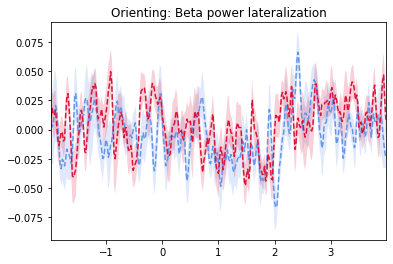

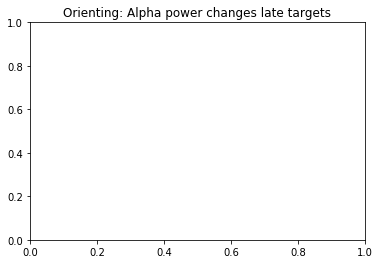

In [53]:
# plot lateralization index for orienting with random target locations known
%matplotlib inline
import seaborn as sb 

#%matplotlib notebook 

time = times#np.squeeze(np.arange(-3. - 1./25., 4., 1./25.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

timewin = [-2., 4.]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('Orienting: Beta power lateralization')
# Plot PO8
for i in list(PowOdictM.keys())[4:6]:
    
    #if 'Early' in i: 
        
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'

        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'

        sb.tsplot(time = time[timeInd], data = PowOdictM[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1)# , colors = colors, linestyles = linestyles)


fig2, ax2 = plt.subplots()
ax2.set_title('Orienting: Alpha power changes late targets')
#color = 'black'
# Plot PO8
for i in list(PowOdictM.keys()):
    
    if 'Late' in i: 
        
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'

        if 'Left' in i:
            linestyle = '-'
        elif 'Right' in i:
            linestyle = '--'

        sb.tsplot(time = time[timeInd], data = PowOdictM[i][:,timeInd], color = color, linestyle = linestyle, ax = ax2, ci = 0)# , colors = colors, linestyles = linestyles)





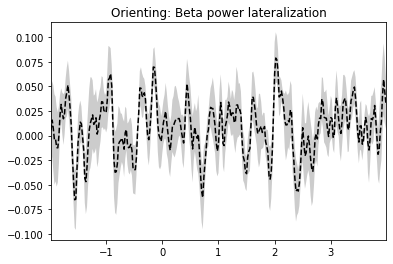

In [54]:
#Plot diff
timewin = [-2., 4.]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('Orienting: Beta power lateralization')
# Plot PO8
color = 'black'
for i in list(PowOdictM.keys())[-1:]:
    
     
        
    #print(LRdict[i].transpose().shape)
    if 'Predicted' in i:
        color = 'Crimson'
    elif 'Random' in i:
        color = 'CornFlowerBlue'

    if 'Early' in i:
        linestyle = '-'
    elif 'Late' in i:
        linestyle = '--'

    sb.tsplot(time = time[timeInd], data = PowOdictM[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1)# , colors = colors, linestyles = linestyles)



In [ ]:
# cluster permutation across time and freq for lateralization
from mne.stats import permutation_cluster_test

#twin = [-1.0, 0.] # memory recall window
#twin = [0.2, 0.8] # anticipation window early target
#twin = [1.0, 2.0] # anticipation window late target
#twin = [0.8, 1.6] # reaction window early target
#twin = [2.0, 2.8] # reaction window late target


twin = [-1., 0.8] # anticipation window 
tInd = (times > twin[0]) & (times < twin[1])
condition2 = PowOdictM['Random'][:,tInd]
condition1 = PowOdictM['Predicted'][:,tInd]

threshold = 2.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=0, n_jobs=1)

In [ ]:
cluster_p_values

In [33]:
# Calculate contra - ipsi / contra + ipsi -- Orienting ALPHA -- keep values on sensor level

# NOTE: 'left' and 'right ' now mean left and right electrode.. 
LeftElec= 'PO7' 
RightElec = 'PO8'

subs = [ 18, 19, 20, 21, 22, 23, 24, 25, 27, 30]
#subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23,  24, 25, 27,29,  30]
# Baseline 
#baseline = [-0.5, -0.15]

times = evokedO_dictAll['S18']['Early/Predicted/Left'].times
#tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 7.5) * (frequencies < 13.0)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[2]))

PowOdictM = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy(), 'Late/Random/Right': emptyNp.copy(),  'Late/Predicted/Right': emptyNp.copy(), 
      'Late/Random/Left': emptyNp.copy(),   'Late/Predicted/Left': emptyNp.copy(),'Late/Predicted': emptyNp.copy(), 'Early/Predicted': emptyNp.copy(),
            'Late/Random': emptyNp.copy(), 'Early/Random': emptyNp.copy()}
num = 0
for i in subs:
    
    
    
    LeftInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(LeftElec)
    RightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(RightElec)
    
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Late/Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    PowOdictM['Early/Random'][num,:] = (PowOdictM['Early/Random/Right'][num,:] + PowOdictM['Early/Random/Left'][num,:])/2
    PowOdictM['Late/Random'][num,:] = (PowOdictM['Late/Random/Right'][num,:] + PowOdictM['Late/Random/Left'][num,:])/2

    PowOdictM['Early/Predicted'][num,:] = (PowOdictM['Early/Predicted/Right'][num,:] + PowOdictM['Early/Predicted/Left'][num,:])/2
    PowOdictM['Late/Predicted'][num,:] = (PowOdictM['Late/Predicted/Right'][num,:] + PowOdictM['Late/Predicted/Left'][num,:])/2

    del contra, ipsi


    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [52]:
# Calculate contra - ipsi / contra + ipsi -- Orienting ALPHA -- keep values on sensor level
# Based on early target expectation, collapsed over early/late trials
# Keep 'early' as an easy place holder to use same plotting function

# NOTE: 'left' and 'right ' now mean left and right electrode.. 
LeftElec= 'PO7' 
RightElec = 'PO8'
#subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23,  24, 25, 27,29,  30]
subs = [11, 12, 14, 16, 17, 22, 23, 24, 29, 30]
#subs = [ 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30]
# Baseline 
#baseline = [-0.5, -0.15]

times = evokedO_dictAll['S18']['Early/Predicted/Left'].times
#tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 7.5) * (frequencies < 13.0)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[2]))

PowOdictM = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy(), 'Random': emptyNp.copy(),
             'Random': emptyNp.copy(),'Predicted': emptyNp.copy(), 'Diff/Left': emptyNp.copy(), 
             'Diff/Right': emptyNp.copy(), 'Diff': emptyNp.copy()
      }
num = 0
for i in subs:
    
    
    
    LeftInd = evokedO_dictAll['S' + str(i)]['Random/Left'].ch_names.index(LeftElec)
    RightInd = evokedO_dictAll['S' + str(i)]['Random/Left'].ch_names.index(RightElec)
    
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Random/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Random/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Random/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Random/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Predicted/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Predicted/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedO_dictAll['S' + str(i)]['Predicted/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedO_dictAll['S' + str(i)]['Predicted/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowOdictM['Early/Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    
    
    
    
    PowOdictM['Random'][num,:] = (PowOdictM['Early/Random/Right'][num,:] + PowOdictM['Early/Random/Left'][num,:])/2
    #PowOdictM['Late/Random'][num,:] = (PowOdictM['Late/Random/Right'][num,:] + PowOdictM['Late/Random/Left'][num,:])/2

    PowOdictM['Predicted'][num,:] = (PowOdictM['Early/Predicted/Right'][num,:] + PowOdictM['Early/Predicted/Left'][num,:])/2
    #PowOdictM['Late/Predicted'][num,:] = (PowOdictM['Late/Predicted/Right'][num,:] + PowOdictM['Late/Predicted/Left'][num,:])/2

    #del contra, ipsi
    
    # add predicted-random contrasts
   
    PowOdictM['Diff/Left'][num,:] = PowOdictM['Early/Predicted/Left'][num,:] - PowOdictM['Early/Random/Left'][num,:]
    PowOdictM['Diff/Right'][num,:] = PowOdictM['Early/Predicted/Right'][num,:] - PowOdictM['Early/Random/Right'][num,:]



    PowOdictM['Diff'][num,:] = (PowOdictM['Diff/Left'][num,:]+ PowOdictM['Diff/Right'][num,:])/2




    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [43]:
emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/RespLeft'].data.shape[1], evokedO_dictAll['S18']['Early/Random/RespLeft'].data.shape[2]))

In [ ]:
# Calculate contra - ipsi / contra + ipsi -- Orienting MOTOR -- keep values on sensor level -- ALL FREQS

# NOTE: 'left' and 'right ' now mean left and right electrode.. 
LeftElec= 'C3' 
RightElec = 'C4'

subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23,  24, 25, 27,29,  30]

# Baseline 
#baseline = [-0.5, -0.15]

times = evokedO_dictAll['S18']['Early/Predicted/RespLeft'].times
#tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

#freqInd = (frequencies > 13.0) * (frequencies < 30.0)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/RespLeft'].data.shape[1], evokedO_dictAll['S18']['Early/Random/RespLeft'].data.shape[2]))

PowOdictM = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy(), 'Late/Random/Right': emptyNp.copy(),  'Late/Predicted/Right': emptyNp.copy(), 
      'Late/Random/Left': emptyNp.copy(),   'Late/Predicted/Left': emptyNp.copy(),'Late/Predicted': emptyNp.copy(), 'Early/Predicted': emptyNp.copy(),
            'Late/Random': emptyNp.copy(), 'Early/Random': emptyNp.copy(), 'EarlyDiff': emptyNp.copy(), 'LateDiff': emptyNp.copy()}
num = 0
for i in subs:
    
    
    
    LeftInd = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].ch_names.index(LeftElec)
    RightInd = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].ch_names.index(RightElec)
    
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[RightInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[RightInd,:,:] 

    PowOdictM['Early/Random/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[LeftInd,:,:] 
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[LeftInd,:,:]  

    PowOdictM['Early/Random/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[LeftInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[LeftInd,:,:]  

    PowOdictM['Early/Predicted/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[RightInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[RightInd,:,:]  

    PowOdictM['Early/Predicted/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[RightInd,:,:] 
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[RightInd,:,:] 

    PowOdictM['Late/Random/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[LeftInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[LeftInd,:,:] 

    PowOdictM['Late/Random/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[LeftInd,:,:] 
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[LeftInd,:,:]  

    PowOdictM['Late/Predicted/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[RightInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[RightInd,:,:]  

    PowOdictM['Late/Predicted/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    PowOdictM['Early/Random'][num,:,:] = (PowOdictM['Early/Random/Right'][num,:,:] + PowOdictM['Early/Random/Left'][num,:,:])/2
    PowOdictM['Late/Random'][num,:,:] = (PowOdictM['Late/Random/Right'][num,:,:] + PowOdictM['Late/Random/Left'][num,:,:])/2

    PowOdictM['Early/Predicted'][num,:,:] = (PowOdictM['Early/Predicted/Right'][num,:,:] + PowOdictM['Early/Predicted/Left'][num,:,:])/2
    PowOdictM['Late/Predicted'][num,:,:] = (PowOdictM['Late/Predicted/Right'][num,:,:] + PowOdictM['Late/Predicted/Left'][num,:,:])/2

    PowOdictM['EarlyDiff'][num,:,:] = PowOdictM['Early/Predicted'][num,:,:] - PowOdictM['Early/Random'][num,:,:]
    PowOdictM['LateDiff'][num,:,:] = PowOdictM['Late/Predicted'][num,:,:] - PowOdictM['Late/Random'][num,:,:]


    
    del contra, ipsi


    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [ ]:
PowOdictM['EarlyDiff'].shape

In [ ]:
np.concatenate?

In [ ]:
# cluster permutation across time and freq for lateralization
from mne.stats import permutation_cluster_test

#twin = [-1.0, 0.] # memory recall window
#twin = [0.2, 0.8] # anticipation window early target
#twin = [1.0, 2.0] # anticipation window late target
twin = [0.8, 1.6] # reaction window early target
#twin = [2.0, 2.8] # reaction window late target


#twin = [2.0, 2.8] # anticipation window late target
tInd = (times > twin[0]) & (times < twin[1])
condition2 = PowOdictM['Early/Random'][:,:,tInd]
condition1 = PowOdictM['Early/Predicted'][:,:,tInd]

threshold = 2.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=0, n_jobs=1)


In [ ]:
cluster_p_values

In [ ]:
times[tInd]

In [ ]:
# plot cluster
%matplotlib notebook
sb.heatmap(data = clusters[0] , xticklabels = times[tInd],  yticklabels = yLbl)

In [ ]:
# Plot TF-lateralization

fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (20,10))
fig.subplots_adjust(hspace=0.3)

fig.suptitle('Time-frequency lateralization')

freqInd = frequencies > 5.0
tInd = (times > -2.0) 

cmap = 'coolwarm'
vmin = -0.15
vmax = 0.15

yLbl = np.round(frequencies, 1)
xLbl= times
xticks = []
for i in xLbl: 
    if i%0.5 == 0.0:
        xticks.append(i)
    else: 
        xticks.append('')

sb.heatmap(data = np.mean(PowOdictM['Late/Predicted'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[0,1], cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[0,1].invert_yaxis()
axes[0,1].set(title= 'Late Predicted')        
        
sb.heatmap(data = np.mean(PowOdictM['Early/Predicted'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[0,0], cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[0,0].invert_yaxis()
axes[0,0].set(title= 'Early Predicted')        
        
sb.heatmap(data = np.mean(PowOdictM['Late/Random'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[1,1],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[1,1].invert_yaxis()
axes[1,1].set(title= 'Late Random')        
        
sb.heatmap(data = np.mean(PowOdictM['Early/Random'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[1,0],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[1,0].invert_yaxis()
axes[1,0].set(title= 'Early Random')

sb.heatmap(data = np.mean(PowOdictM['EarlyDiff'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[2,0],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[2,0].invert_yaxis()
axes[2,0].set(title= 'Early Diff plot: Predicted - random')

sb.heatmap(data = np.mean(PowOdictM['LateDiff'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[2,1],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[2,1].invert_yaxis()
axes[2,1].set(title= 'Late Diff plot: Predicted - random')
axes[2,1].axvline(0.0, color = 'gray')

In [44]:
# Calculate contra - ipsi / contra + ipsi -- Orienting VISUAL -- keep values on sensor level -- ALL FREQS

# NOTE: 'left' and 'right ' now mean left and right electrode.. 
LeftElec= 'PO7' 
RightElec = 'PO8'

# Baseline 
#baseline = [-0.5, -0.15]

times = evokedO_dictAll['S18']['Early/Predicted/Left'].times
#tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

#freqInd = (frequencies > 13.0) * (frequencies < 30.0)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[1], evokedO_dictAll['S18']['Early/Random/RespLeft'].data.shape[2]))

PowOdict = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy(), 'Late/Random/Right': emptyNp.copy(),  'Late/Predicted/Right': emptyNp.copy(), 
      'Late/Random/Left': emptyNp.copy(),   'Late/Predicted/Left': emptyNp.copy(),'Late/Predicted': emptyNp.copy(), 'Early/Predicted': emptyNp.copy(),
            'Late/Random': emptyNp.copy(), 'Early/Random': emptyNp.copy(), 'EarlyDiff': emptyNp.copy(), 'LateDiff': emptyNp.copy()}
num = 0
for i in subs:
    
    
    
    LeftInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(LeftElec)
    RightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(RightElec)
    
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[RightInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[RightInd,:,:] 

    PowOdict['Early/Random/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[LeftInd,:,:] 
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[LeftInd,:,:]  

    PowOdict['Early/Random/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[LeftInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[LeftInd,:,:]  

    PowOdict['Early/Predicted/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[RightInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[RightInd,:,:]  

    PowOdict['Early/Predicted/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[RightInd,:,:] 
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[RightInd,:,:] 

    PowOdict['Late/Random/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[LeftInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[LeftInd,:,:] 

    PowOdict['Late/Random/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[LeftInd,:,:] 
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[LeftInd,:,:]  

    PowOdict['Late/Predicted/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[RightInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[RightInd,:,:]  

    PowOdict['Late/Predicted/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    PowOdict['Early/Random'][num,:,:] = (PowOdict['Early/Random/Right'][num,:,:] + PowOdict['Early/Random/Left'][num,:,:])/2
    PowOdict['Late/Random'][num,:,:] = (PowOdict['Late/Random/Right'][num,:,:] + PowOdict['Late/Random/Left'][num,:,:])/2

    PowOdict['Early/Predicted'][num,:,:] = (PowOdict['Early/Predicted/Right'][num,:,:] + PowOdict['Early/Predicted/Left'][num,:,:])/2
    PowOdict['Late/Predicted'][num,:,:] = (PowOdict['Late/Predicted/Right'][num,:,:] + PowOdict['Late/Predicted/Left'][num,:,:])/2

    PowOdict['EarlyDiff'][num,:,:] = PowOdict['Early/Predicted'][num,:,:] - PowOdict['Early/Random'][num,:,:]
    PowOdict['LateDiff'][num,:,:] = PowOdict['Late/Predicted'][num,:,:] - PowOdict['Late/Random'][num,:,:]


    
    del contra, ipsi


    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [ ]:
# Plot TF-lateralization

fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (20,10))
fig.subplots_adjust(hspace=0.3)

fig.suptitle('Time-frequency lateralization')

freqInd = frequencies > 0.0
tInd = (times > -2.0) 

cmap = 'coolwarm'
vmin = -0.15
vmax = 0.15

yLbl = np.round(frequencies, 1)
xLbl= times
xticks = []
for i in xLbl: 
    if i%0.5 == 0.0:
        xticks.append(i)
    else: 
        xticks.append('')

sb.heatmap(data = np.mean(PowOdict['Late/Predicted'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[0,1], cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[0,1].invert_yaxis()
axes[0,1].set(title= 'Late Predicted')        
        
sb.heatmap(data = np.mean(PowOdict['Early/Predicted'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[0,0], cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[0,0].invert_yaxis()
axes[0,0].set(title= 'Early Predicted')        
        
sb.heatmap(data = np.mean(PowOdict['Late/Random'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[1,1],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[1,1].invert_yaxis()
axes[1,1].set(title= 'Late Random')        
        
sb.heatmap(data = np.mean(PowOdict['Early/Random'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[1,0],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[1,0].invert_yaxis()
axes[1,0].set(title= 'Early Random')

sb.heatmap(data = np.mean(PowOdict['EarlyDiff'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[2,0],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[2,0].invert_yaxis()
axes[2,0].set(title= 'Early Diff plot: Predicted - random')

sb.heatmap(data = np.mean(PowOdict['LateDiff'][:,freqInd,:], axis = 0), xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[2,1],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[2,1].invert_yaxis()
axes[2,1].set(title= 'Late Diff plot: Predicted - random')
axes[2,1].axvline(0.0, color = 'gray')

In [ ]:
# Plot TF-lateralization ---- individual subject
subInd = 7

fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (20,10))
fig.subplots_adjust(hspace=0.3)

fig.suptitle('Time-frequency lateralization')

freqInd = frequencies > 0.0
tInd = (times > -2.0) 

cmap = 'coolwarm'
vmin = -0.15
vmax = 0.15

yLbl = np.round(frequencies, 1)
xLbl= times
xticks = []
for i in xLbl: 
    if i%0.5 == 0.0:
        xticks.append(i)
    else: 
        xticks.append('')

sb.heatmap(data = PowOdict['Late/Predicted'][subInd,freqInd,:], xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[0,1], cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[0,1].invert_yaxis()
axes[0,1].set(title= 'Late Predicted')        
        
sb.heatmap(data = PowOdict['Early/Predicted'][subInd,freqInd,:], xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[0,0], cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[0,0].invert_yaxis()
axes[0,0].set(title= 'Early Predicted')        
        
sb.heatmap(data = PowOdict['Late/Random'][subInd,freqInd,:], xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[1,1],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[1,1].invert_yaxis()
axes[1,1].set(title= 'Late Random')        
        
sb.heatmap(data = PowOdict['Early/Random'][subInd,freqInd,:], xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[1,0],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[1,0].invert_yaxis()
axes[1,0].set(title= 'Early Random')

sb.heatmap(data = PowOdict['EarlyDiff'][subInd,freqInd,:], xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[2,0],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[2,0].invert_yaxis()
axes[2,0].set(title= 'Early Diff plot: Predicted - random')

sb.heatmap(data = PowOdict['LateDiff'][subInd,freqInd,:], xticklabels = xticks,  yticklabels = yLbl[freqInd], ax = axes[2,1],cmap = cmap, vmin = vmin, vmax = vmax)# , x = xLbl, y = yLbl)
axes[2,1].invert_yaxis()
axes[2,1].set(title= 'Late Diff plot: Predicted - random')
axes[2,1].axvline(0.0, color = 'gray')

In [ ]:
# plot lateralization index for orienting with random target locations known
import seaborn as sb 

%matplotlib notebook 

time = times#np.squeeze(np.arange(-3. - 1./25., 4., 1./25.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

timewin = [-2., 4.]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('Orienting: Motor beta power changes early targets')
# Plot PO8
for i in list(PowOdictM.keys()):
    
    if 'Left' in i or 'Right' in i:
        #print(LRdict[i].transpose().shape)
        if 'Early' in i:
            
            if 'Predicted' in i:
                color = 'Crimson'
            elif 'Random' in i:
                color = 'CornFlowerBlue'

            if 'Left' in i:
                linestyle = '-'
            elif 'Right' in i:
                linestyle = '--'

            sb.tsplot(time = time[timeInd], data = PowOdictM[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1, ci = 0)# , colors = colors, linestyles = linestyles)


fig2, ax2 = plt.subplots()
ax2.set_title('Orienting: Motor beta power lateralization averaged ')
for i in list(PowOdictM.keys()):

    if 'Late' in i:
        if not ('Left' in i or 'Right' in i):
            #print(LRdict[i].transpose().shape)
            if 'Predicted' in i:
                color = 'Crimson'
            elif 'Random' in i:
                color = 'CornFlowerBlue'

            #if 'Early' in i:
               #     linestyle = '-'
            #elif 'Late' in i:
               #     linestyle = '--'
            #else:

            linestyle = '-'
            sb.tsplot(time = time[timeInd], data = PowOdictM[i][:,timeInd], color = color, linestyle = linestyle, ax = ax2, ci =68)# , colors = colors, linestyles = linestyles)


        
    



In [ ]:
# Calculate contra - ipsi / contra + ipsi -- Learning ALPHA -- keep values on sensor level

# NOTE: 'left' and 'right ' now mean left and right electrode.. 
LeftElec= 'PO7' 
RightElec = 'PO8'

subs = [1, 3,  6,7, 10, 11, 12, 14,  16, 17, 18, 19, 20, 21, 22, 23,  24, 25, 27,29,  30]


# Baseline 
#baseline = [-0.5, -0.15]

times = evokedL_dictAll['S18']['Predicted/Left'].times
#tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 7.5) * (frequencies < 13.0)

emptyNp = np.zeros((len(subs), evokedL_dictAll['S18']['Random/Left'].data.shape[2]))

PowLdictM = {'Random/Right': emptyNp.copy(),  'Predicted/Right': emptyNp.copy(), 
      'Random/Left': emptyNp.copy(),   'Predicted/Left': emptyNp.copy(),'Random': emptyNp.copy(), 'Predicted': emptyNp.copy()}
num = 0
for i in subs:
    
    
    
    LeftInd = evokedL_dictAll['S' + str(i)]['Random/Left'].ch_names.index(LeftElec)
    RightInd = evokedL_dictAll['S' + str(i)]['Random/Left'].ch_names.index(RightElec)
    
    
    contra = np.mean(evokedL_dictAll['S' + str(i)]['Random/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedL_dictAll['S' + str(i)]['Random/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowLdictM['Random/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    
    
    contra = np.mean(evokedL_dictAll['S' + str(i)]['Random/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedL_dictAll['S' + str(i)]['Random/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowLdictM['Random/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Right'].data[LeftInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Left'].data[LeftInd,freqInd,:], axis = 0)  

    PowLdictM['Predicted/Left'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Left'].data[RightInd,freqInd,:], axis = 0)  
    ipsi = np.mean(evokedL_dictAll['S' + str(i)]['Predicted/Right'].data[RightInd,freqInd,:], axis = 0)  

    PowLdictM['Predicted/Right'][num,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    

    PowLdictM['Random'][num,:] = (PowLdictM['Random/Right'][num,:] + PowLdictM['Random/Left'][num,:])/2
    PowLdictM['Predicted'][num,:] = (PowLdictM['Predicted/Right'][num,:] + PowLdictM['Predicted/Left'][num,:])/2

   
    


    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [ ]:
fig2, ax2 = plt.subplots()
ax2.set_title('Learning: Visual alpha power lateralization averaged ')
for i in list(PowLdictM.keys()):

    
    if not ('Left' in i or 'Right' in i):
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'

        #if 'Early' in i:
           #     linestyle = '-'
        #elif 'Late' in i:
           #     linestyle = '--'
        #else:

        linestyle = '-'
        sb.tsplot(time = time[timeInd], data = PowLdictM[i][:,timeInd], color = color, linestyle = linestyle, ax = ax2, ci =68)# , colors = colors, linestyles = linestyles)


        

In [ ]:
from mne.stats import permutation_cluster_test

condition1 = PowLdictM['Random']
condition2 = PowLdictM['Predicted']

threshold = 2.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=0, n_jobs=1)

In [ ]:
cluster_p_values

In [ ]:
# Plot results
#times = GAVG_orienting['Early/Predicted'].times
times1 = times
plt.close('all')
plt.subplot(211)
#plt.title('Channel : ' + channel)
plt.plot(times1, np.mean(condition1, axis = 0) - np.mean(condition2, axis = 0),
         label="Lateralization contrast(Predicted - Random)")
plt.ylabel("Lat index")
plt.legend()
plt.subplot(212)
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        h = plt.axvspan(times1[c.start], times1[c.stop - 1],
                        color='r', alpha=0.3)
    else:
        plt.axvspan(times1[c.start], times1[c.stop - 1], color=(0.3, 0.3, 0.3),
                    alpha=0.3)
hf = plt.plot(times1, T_obs, 'g')
#plt.legend((h, ), ('cluster p-value < 0.05', ))
plt.xlabel("time (ms)")
plt.ylabel("f-values")
#ax.axvline(0.8, color = 'gray', linestyle = '-', label = 'Target 1')
#ax.axvline(2.0, color = 'gray', linestyle = '-', label = 'Target 2')
plt.show()

In [ ]:
# Calculate contra - ipsi / contra + ipsi -- Orienting MOTOR -- keep values on sensor level - TFR code

# NOTE: 'left' and 'right ' now mean left and right electrode.. 
LeftElec= 'C3' 
RightElec = 'C4'

# Baseline 
#baseline = [-0.5, -0.15]

times = evokedO_dictAll['S18']['Early/Predicted/RespLeft'].times
tBL = (times > baseline[0] ) * (times<baseline[1])
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 13.0) * (frequencies < 30.0)

emptyNp = np.zeros((len(subs),evokedO_dictAll['S18']['Early/Random/RespLeft'].data.shape[1],  evokedO_dictAll['S18']['Early/Random/RespLeft'].data.shape[2]))

PowOdictM = {'Early/Random/Right': emptyNp.copy(),  'Early/Predicted/Right': emptyNp.copy(), 
      'Early/Random/Left': emptyNp.copy(),   'Early/Predicted/Left': emptyNp.copy(), 'Late/Random/Right': emptyNp.copy(),  'Late/Predicted/Right': emptyNp.copy(), 
      'Late/Random/Left': emptyNp.copy(),   'Late/Predicted/Left': emptyNp.copy()}
num = 0
for i in subs:
    
    del contra, ipsi
    
    LeftInd = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].ch_names.index(LeftElec)
    RightInd = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].ch_names.index(RightElec)
    
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[RightInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[RightInd,:,:]  

    PowOdictM['Early/Random/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[LeftInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[LeftInd,:,:]  

    PowOdictM['Early/Random/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[LeftInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[LeftInd,:,:]  

    PowOdictM['Early/Predicted/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[RightInd,:,:] 
    ipsi = evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[RightInd,:,:] 

    PowOdictM['Early/Predicted/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[RightInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[RightInd,:,:] 

    PowOdictM['Late/Random/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[LeftInd,:,:] 
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[LeftInd,:,:]  

    PowOdictM['Late/Random/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[LeftInd,:,:]  
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[LeftInd,:,:] 

    PowOdictM['Late/Predicted/Left'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    del contra, ipsi
    
    contra = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[RightInd,:,:] 
    ipsi = evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[RightInd,:,:]  

    PowOdictM['Late/Predicted/Right'][num,:,:] = (contra - ipsi)/ (contra + ipsi)
    
    
    #LRdictAll['S' + str(i)] = LRdict
    num += 1

In [ ]:
# plot lateralization index for orienting with random target locations known -- can't figure out how to insert TFR into plotting funciton

import seaborn as sb 

%matplotlib notebook 

time = times#np.squeeze(np.arange(-3. - 1./25., 4., 1./25.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")
info = GAVG_orienting['Early/Predicted'].info.copy()
info['ch_names'] = ['ch1']
info['chs'] = info['chs'][0]
timewin = [-2., 4.]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1 = plt.subplots(2,4)
#ax1.set_title('Orienting: Motor beta power changes early targets')
# Plot PO8

for i in list(PowOdictM.keys()):
    
    if 'Early' in i: 
        
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            titleAdd1 = 'Predicted'
            
        elif 'Random' in i:
            titleAdd1 = 'Random'

        if 'Left' in i:
            titleAdd = 'C3'
        elif 'Right' in i:
            titileAdd = 'C4'
        
        dat1 = np.zeros((1,PowOdictM[i].shape[1], PowOdictM[i].shape[2]))
        dat1[0,:,:] = np.mean(PowOdictM[i], axis = 0)
        dat = mne.time_frequency.AverageTFR(data = dat1,info = info, nave = PowOdictM[i].shape[0],  times = evokedO_dictAll['S18']['Early/Predicted/RespLeft'].times, freqs = frequencies)
        
        dat.plot()
        #sb.tsplot(time = time[timeInd], data = PowOdictM[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1, ci = 0)# , colors = colors, linestyles = linestyles)



In [ ]:
#GAVG_orienting['Early/Predicted'].info = GAVG_orienting['Early/Random'].info.copy()


info

In [ ]:
%matplotlib notebook

plt.plot(time[timeInd],PowOdictM['Early/Random/Right'])

In [ ]:
GAVG_orienting['Early/Predicted/RespLeft'].plot('C4', baseline = (-0.5, -0.2 ), mode = 'percent')

In [ ]:
GAVG_orienting['Early/Predicted/RespLeft'].plot?

In [ ]:
GAVG_orienting['Early/Predicted/RespLeft'].plot

In [ ]:
GAVG_orienting['Early/Predicted/RespLeft'].plot

In [ ]:
new_Evoked.plot_top




In [ ]:
# Add difference plots

tmin = 1.2
tmax = 1.6
times = [1.2, 1.6]
baseline = (-0.5, -0.2)
mode = 'percent'
fmin = 13
fmax = 30

condition1 = 'Early/Predicted/RespLeft'
condition2 = 'Early/Predicted/RespRight'
# 
new_Evoked = GAVG_orienting[condition1].copy()
new_Evoked._data = GAVG_orienting[condition1]._data - GAVG_orienting[condition2]._data

new_Evoked.plot_topomap(tmin = tmin, tmax = tmax, fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)

tmin = 2.4
tmax = 2.8
#times = [2.4, 2.6]

condition1 = 'Late/Predicted/RespLeft'
condition2 = 'Late/Predicted/RespRight'
# 
#new_Evoked = GAVG_orienting[condition1].copy()
new_Evoked._data = GAVG_orienting[condition1]._data - GAVG_orienting[condition2]._data

new_Evoked.plot_topomap(tmin = tmin, tmax = tmax,fmin = fmin, fmax = fmax, baseline = baseline)


In [ ]:
tmin = 1.3
tmax = 1.5
times = [1.2, 1.6]
baseline = (-0.5, -0.2)
mode = 'percent'
fmin = 8
fmax = 13
condition = 'Early/Random/RespLeft'
GAVG_orienting[condition].plot_topomap(tmin = tmin, tmax = tmax,  fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)
condition = 'Early/Random/RespRight'
GAVG_orienting[condition].plot_topomap(tmin = tmin, tmax = tmax,  fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)


condition = 'Early/Predicted/RespLeft'
GAVG_orienting[condition].plot_topomap(tmin = tmin, tmax = tmax, fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)
condition = 'Early/Predicted/RespRight'
GAVG_orienting[condition].plot_topomap(tmin = tmin, tmax = tmax, fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)

tmin = 2.5
tmax = 2.7
times = [2.4, 2.6]
condition = 'Late/Random/RespLeft'
GAVG_orienting[condition].plot_topomap(tmin = tmin, tmax = tmax, fmin = fmin, fmax = fmax, baseline = baseline, mode=mode)
condition = 'Late/Predicted/RespRight'
GAVG_orienting[condition].plot_topomap(tmin = tmin, tmax = tmax, fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)

In [ ]:
tmin = 1.3
tmax = 1.5
times = [1.1, 1.4]
baseline = (-0.5, -0.2)
mode = 'percent'
fmin = 8
fmax = 13
condition = 'Random/Left'
GAVG_learning[condition].plot_topomap(tmin = tmin, tmax = tmax,  fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)
condition = 'Random/Right'
GAVG_learning[condition].plot_topomap(tmin = tmin, tmax = tmax,  fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)


condition = 'Predicted/Left'
GAVG_learning[condition].plot_topomap(tmin = tmin, tmax = tmax, fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)
condition = 'Predicted/Right'
GAVG_learning[condition].plot_topomap(tmin = tmin, tmax = tmax, fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)



In [ ]:
tmin = -0.7
tmax = -0.4
#times = [0.4, 0.7]
baseline = (-1.5, -1.3)
mode = 'percent'
fmin = 8
fmax = 13
condition = 'Predicted/Left'
GAVG_learning[condition].plot_topomap(tmin = tmin, tmax = tmax,  fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)
condition = 'Predicted/Right'
GAVG_learning[condition].plot_topomap(tmin = tmin, tmax = tmax,  fmin = fmin, fmax = fmax, baseline = baseline, mode = mode)



In [ ]:
baseline = (-0.3, -0.1)
mode = 'percent'

evoked_dict= dict()
evoked_dict['Predicted/Left'] = GAVG_learning['Predicted/Left'].apply_baseline(baseline = baseline, mode = mode)
evoked_dict['Predicted/Right'] = GAVG_learning['Predicted/Right'].apply_baseline(baseline = baseline, mode = mode)
evoked_dict['Random/Left'] = GAVG_learning['Random/Left'].apply_baseline(baseline = baseline, mode = mode)
evoked_dict['Random/Right'] = GAVG_learning['Random/Right'].apply_baseline(baseline = baseline, mode = mode)

pick = evoked_dict["Predicted/Left"].ch_names.index('PZ')
linestyles = dict(Left = '-', Right = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

fmin = 13
fmax = 30

baseline = (-0.3, -0.1)
mode = 'percent'

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                             linestyles=linestyles, split_legend=True)

In [ ]:
evokedO_dictAll['S18']['Early/Predicted']._data.shape

In [ ]:
# Calculate difference waves for motor beta

leftElec = 'C3'
rightElec = 'C4'
#LRdict = dict()
#LRdictAll = dict()

freqInd = (frequencies > 13.0) * (frequencies < 30)

emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[2]))

LRdict = {'C4/Random/Early': emptyNp.copy(), 'C3/Random/Early': emptyNp.copy(), 'C3/Predicted/Early': emptyNp.copy(), 'C4/Predicted/Early': emptyNp.copy(),
      'C4/Random/Late': emptyNp.copy(), 'C3/Random/Late': emptyNp.copy(),  'C3/Predicted/Late': emptyNp.copy(), 'C4/Predicted/Late': emptyNp.copy()}
num = 0
for i in subs:
    
    
    leftInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(leftElec)
    rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    LRdict['C4/Random/Early'][num,:] = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[rightInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[rightInd,freqInd, :], axis = 0)
    LRdict['C3/Random/Early'][num,:] = np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespRight'].data[leftInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[leftInd, freqInd,:], axis = 0)

    LRdict['C3/Predicted/Early'][num,:]= np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[rightInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[rightInd,freqInd,:], axis = 0)
    LRdict['C4/Predicted/Early'][num,:]= np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespRight'].data[leftInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/RespLeft'].data[leftInd,freqInd,:], axis = 0)

    LRdict['C4/Random/Late'][num,:]= np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[rightInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[rightInd,freqInd,:], axis = 0)
    LRdict['C3/Random/Late'][num,:] = np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespRight'].data[leftInd, freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Late/Random/RespLeft'].data[leftInd,freqInd,:], axis = 0)

    LRdict['C3/Predicted/Late'][num,:]= np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[rightInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[rightInd,freqInd,:], axis = 0)
    LRdict['C4/Predicted/Late'][num,:] = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespLeft'].data[leftInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/RespRight'].data[leftInd,freqInd,:], axis = 0)

    #LRdictAll['S' + str(i)] = LRdict
    num += 1



In [ ]:
# Calculate difference waves for n2pc



leftElec = 'PO7'
rightElec = 'PO8'
#LRdict = dict()
#LRdictAll = dict()
freqInd = (frequencies > 8.0) * (frequencies < 13)
emptyNp = np.zeros((len(subs), evokedO_dictAll['S18']['Early/Random/Left'].data.shape[2]))

LRdict = {'PO8/Random/Early': emptyNp.copy(), 'PO7/Random/Early': emptyNp.copy(), 'PO7/Predicted/Early': emptyNp.copy(), 'PO8/Predicted/Early': emptyNp.copy(),
      'PO8/Random/Late': emptyNp.copy(), 'PO7/Random/Late': emptyNp.copy(),  'PO7/Predicted/Late': emptyNp.copy(), 'PO8/Predicted/Late': emptyNp.copy()}
num = 0
for i in subs:
    
    
    leftInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(leftElec)
    rightInd = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].ch_names.index(rightElec)
    
    # Contra - ipsi, for left electrode and right electrode
    #LRdict['PO8/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[rightInd,:]
    #LRdict['PO7/Random/Early'][num,:] = evokedO_dictAll['S' + str(i)]['Early/Random/Left'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Early/Random/Right'].data[leftInd,:]
        
    LRdict['PO7/Predicted/Early'][num,:]= np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[rightInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[rightInd,freqInd,:], axis = 0)
    LRdict['PO8/Predicted/Early'][num,:]= np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Left'].data[leftInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Early/Predicted/Right'].data[leftInd,freqInd,:], axis = 0)

    #LRdict['PO8/Random/Late'][num,:]= evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[rightInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[rightInd,:]
    #LRdict['PO7/Random/Late'][num,:] = evokedO_dictAll['S' + str(i)]['Late/Random/Left'].data[leftInd,:] - evokedO_dictAll['S' + str(i)]['Late/Random/Right'].data[leftInd,:]

    LRdict['PO7/Predicted/Late'][num,:]= np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[rightInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[rightInd,freqInd,:], axis = 0)
    LRdict['PO8/Predicted/Late'][num,:] = np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Left'].data[leftInd,freqInd,:], axis = 0) - np.mean(evokedO_dictAll['S' + str(i)]['Late/Predicted/Right'].data[leftInd,freqInd,:], axis = 0)

    #LRdictAll['S' + str(i)] = LRdict
    num += 1



In [ ]:
import seaborn as sb

%matplotlib notebook 

time = np.squeeze(np.arange(-3. - 1./25., 4., 1./25.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

timewin = [0, 3]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('PO8 contra - ipsi')
# Plot PO8
for i in list(LRdict.keys()):
    if 'PO8' in i:
        print(time.shape)
        print(LRdict[i].shape)
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'
        
        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'
        
        sb.tsplot(time = time[timeInd], data = LRdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1)# , colors = colors, linestyles = linestyles)
        

        
fig2, ax2 = plt.subplots()

ax2.set_title('PO7 contra - ipsi')

 # Plot PO7
for i in list(LRdict.keys()):
    if 'PO7' in i:
        print(time.shape)
        print(LRdict[i].shape)
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'
        
        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'
        
        sb.tsplot(time = time[timeInd], data = LRdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax2)#

In [ ]:
import seaborn as sb

%matplotlib notebook 

time = np.squeeze(np.arange(-3. - 1./25., 4., 1./25.))#evokedO_dictAll['S18']['Early/Random'].info
linestyles = dict(Early = '-', Late = '--')
colors = dict(Predicted = "Crimson", Random = "CornFlowerBlue")

timewin = [0, 3]
timeInd = (time > timewin[0]) * (time< timewin[1])
fig1, ax1 = plt.subplots()
ax1.set_title('C4 contra - ipsi')
# Plot PO8
for i in list(LRdict.keys()):
    if 'C4' in i:
        print(time.shape)
        print(LRdict[i].shape)
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'
        
        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'
        
        sb.tsplot(time = time[timeInd], data = LRdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax1)# , colors = colors, linestyles = linestyles)
        

        
fig2, ax2 = plt.subplots()

ax2.set_title('C3 contra - ipsi')

 # Plot PO7
for i in list(LRdict.keys()):
    if 'C3' in i:
        print(time.shape)
        print(LRdict[i].shape)
        #print(LRdict[i].transpose().shape)
        if 'Predicted' in i:
            color = 'Crimson'
        elif 'Random' in i:
            color = 'CornFlowerBlue'
        
        if 'Early' in i:
            linestyle = '-'
        elif 'Late' in i:
            linestyle = '--'
        
        sb.tsplot(time = time[timeInd], data = LRdict[i][:,timeInd], color = color, linestyle = linestyle, ax = ax2)#

In [ ]:
evokedO_dictAll['S' + str(i)]['Early/Random/RespLeft'].data[rightInd,freqInd,:].shape

In [ ]:
rightInd

In [ ]:
freqInd

In [ ]:
import numpy as np

from scipy import linalg

from .. import pick_types
from ..utils import _validate_type, _ensure_int
from ..io import BaseRaw
from ..io.constants import FIFF
from ..epochs import BaseEpochs
from ..evoked import Evoked
from ..bem import fit_sphere_to_headshape
from ..channels.interpolation import _calc_g, _calc_h


def _prepare_G(G, lambda2):
    G.flat[::len(G) + 1] += lambda2
    # compute the CSD
    Gi = linalg.inv(G)

    TC = Gi.sum(0)
    sgi = np.sum(TC)  # compute sum total

    return Gi, TC, sgi


def _compute_csd(G_precomputed, H, radius):
    """Compute the CSD."""
    n_channels = H.shape[0]
    data = np.eye(n_channels)
    mu = data.mean(0)
    Z = data - mu

    Gi, TC, sgi = G_precomputed

    Cp2 = np.dot(Gi, Z)
    c02 = np.sum(Cp2, axis=0) / sgi
    C2 = Cp2 - np.dot(TC[:, np.newaxis], c02[np.newaxis, :])
    X = np.dot(C2.T, H).T / radius ** 2
    return X


def compute_current_source_density(inst, sphere='auto', lambda2=1e-5,
                                   stiffness=4, n_legendre_terms=50,
                                   copy=True):
    """Get the current source density (CSD) transformation.
    Transformation based on spherical spline surface Laplacian [1]_ [2]_ [3]_.
    Parameters
    ----------
    inst : instance of Raw, Epochs or Evoked
        The data to be transformed.
    sphere : array-like, shape (4,) | str
        The sphere, head-model of the form (x, y, z, r) where x, y, z
        is the center of the sphere and r is the radius in meters.
        Can also be "auto" to use a digitization-based fit.
    lambda2 : float
        Regularization parameter, produces smoothness. Defaults to 1e-5.
    stiffness : float
        Stiffness of the spline.
    n_legendre_terms : int
        Number of Legendre terms to evaluate.
    copy : bool
        Whether to overwrite instance data or create a copy.
    Returns
    -------
    inst_csd : instance of Raw, Epochs or Evoked
        The transformed data. Output type will match input type.
    Notes
    -----
    This function applies an average reference to the data if copy is False.
    Do not transform CSD data to source space.
    .. versionadded:: 0.20
    References
    ----------
    .. [1] Perrin F, Bertrand O, Pernier J. "Scalp current density mapping:
           Value and estimation from potential data." IEEE Trans Biomed Eng.
           1987;34(4):283–288.
    .. [2] Perrin F, Pernier J, Bertrand O, Echallier JF. "Spherical splines
           for scalp potential and current density mapping."
           Electroenceph Clin Neurophysiol. 1989;72(2):184–187.
    .. [3] Kayser J, Tenke CE. "On the benefits of using surface Laplacian
           (Current Source Density) methodology in electrophysiology.
           Int J Psychophysiol. 2015 Sep; 97(3): 171–173.
    """
    _validate_type(inst, (BaseEpochs, BaseRaw, Evoked), 'inst')

    if inst.info['custom_ref_applied'] == FIFF.FIFFV_MNE_CUSTOM_REF_CSD:
        raise ValueError('CSD already applied, should not be reapplied')

    inst = inst.copy() if copy else inst

    picks = pick_types(inst.info, meg=False, eeg=True, exclude=[])

    if any([ch in np.array(inst.ch_names)[picks] for ch in inst.info['bads']]):
        raise ValueError('CSD cannot be computed with bad EEG channels. Either'
                         ' drop (inst.drop_channels(inst.info[\'bads\']) '
                         'or interpolate (`inst.interpolate_bads()`) '
                         'bad EEG channels.')

    if len(picks) == 0:
        raise ValueError('No EEG channels found.')

    _validate_type(lambda2, 'numeric', 'lambda2')
    if not 0 <= lambda2 < 1:
        raise ValueError('lambda2 must be between 0 and 1, got %s' % lambda2)

    _validate_type(stiffness, 'numeric', 'stiffness')
    if stiffness < 0:
        raise ValueError('stiffness must be non-negative got %s' % stiffness)

    n_legendre_terms = _ensure_int(n_legendre_terms, 'n_legendre_terms')
    if n_legendre_terms < 1:
        raise ValueError('n_legendre_terms must be greater than 0, '
                         'got %s' % n_legendre_terms)

    if sphere == 'auto':
        radius, origin_head, origin_device = fit_sphere_to_headshape(inst.info)
        x, y, z = origin_head - origin_device
        sphere = (x, y, z, radius)
    _validate_type(sphere, tuple, 'sphere')
    x, y, z, radius = sphere
    _validate_type(x, 'numeric', 'x')
    _validate_type(y, 'numeric', 'y')
    _validate_type(z, 'numeric', 'z')
    _validate_type(radius, 'numeric', 'radius')
    if radius <= 0:
        raise ValueError('sphere radius must be greater than 0, '
                         'got %s' % radius)

    _validate_type(copy, (bool), 'copy')

    pos = np.array([inst.info['chs'][pick]['loc'][:3] for pick in picks])
    if not np.isfinite(pos).all() or np.isclose(pos, 0.).all(1).any():
        raise ValueError('Zero or infinite position found in chs')
    pos -= (x, y, z)

    G = _calc_g(np.dot(pos, pos.T), stiffness=stiffness,
                n_legendre_terms=n_legendre_terms)
    H = _calc_h(np.dot(pos, pos.T), stiffness=stiffness,
                n_legendre_terms=n_legendre_terms)

    G_precomputed = _prepare_G(G, lambda2)

    trans_csd = _compute_csd(G_precomputed=G_precomputed,
                             H=H, radius=radius)

    epochs = [inst._data] if not isinstance(inst, BaseEpochs) else inst._data
    for epo in epochs:
        epo[picks] = np.dot(trans_csd, epo[picks])
    inst.info['custom_ref_applied'] = FIFF.FIFFV_MNE_CUSTOM_REF_CSD
    for pick in picks:
        inst.info['chs'][pick].update(coil_type=FIFF.FIFFV_COIL_EEG_CSD,
                                      unit=FIFF.FIFF_UNIT_V_M2)
    return inst

# References
# ----------
#
# [1] Perrin F, Bertrand O, Pernier J. "Scalp current density mapping:
#     Value and estimation from potential data." IEEE Trans Biomed Eng.
#     1987;34(4):283–288.
#
# [2] Perrin F, Pernier J, Bertrand O, Echallier JF. "Spherical splines
#     for scalp potential and current density mapping."
#     [Corrigenda EEG 02274, EEG Clin. Neurophysiol., 1990, 76, 565]
#     Electroenceph Clin Neurophysiol. 1989;72(2):184–187.
#
# [3] Kayser J, Tenke CE. "On the benefits of using surface Laplacian
#     (Current Source Density) methodology in electrophysiology."
#     Int J Psychophysiol. 2015 Sep; 97(3): 171–173.